# Optuna Tuning | AdaBoostClassifier
**AdaBoostClassifier** (Classifier) hyper-parameter tuning for the [UCI dataset](https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008). The dataset represents ten years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks.

> **[CAUTION]** Do <u>NOT</u> execute "Run All", that will tell Optuna to run hyper-parameter tuning, regardless of whether you have already done it or not. Avoid running the _"Hyper-parameter tuning"_ subsections if you don't have to.

## **0. Initial Setup**
Taking care of package imports, defining work constants, and loading all necessary datasets.

### 0.1 Python imports

In [1]:
# Data Analysis
import numpy as np
import pandas as pd

# Hyperparameter optimization
import optuna

# Machine learning
import os

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Visualization configurations
pd.set_option('display.max_columns', 60)
plt.style.use('ggplot')
sns.set_style('white')

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from collections import Counter

from imblearn.combine import SMOTETomek
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks

from optuna.storages import JournalStorage
from optuna.storages.journal import JournalFileBackend

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, fbeta_score, make_scorer, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import AdaBoostClassifier


### 0.2 Constants

In [3]:
DATA_PATH = '../data/original/'
DATA_PATH_PROCESSED = '../data/processed/'

MODEL_NAME = 'ab' # Modify this to the model you are using

OPTUNA_PATH = '../optuna/'
OPTUNA_DIR = OPTUNA_PATH + MODEL_NAME + '/'

STUDY_NAME = "Diabetes_130-US"
STUDY_PATH_NONE = OPTUNA_DIR + f"optuna_{MODEL_NAME}_none.log"
STUDY_PATH_RUS = OPTUNA_DIR + f"optuna_{MODEL_NAME}_rus.log"
STUDY_PATH_SMOTE = OPTUNA_DIR + f"optuna_{MODEL_NAME}_smote.log"
STUDY_PATH_SMOTE_TOMEK = OPTUNA_DIR + f"optuna_{MODEL_NAME}_smote-tomek.log"

# Ensure the directories exist
os.makedirs(OPTUNA_DIR, exist_ok=True)
os.makedirs(os.path.dirname(STUDY_PATH_NONE), exist_ok=True)

N_TRIALS = 100
RANDOM_STATE = 38

SCORE_NAME = 'F1-Score'
SCORING = make_scorer(fbeta_score, beta=1, average='macro')

### 0.3 Loading datasets

In [4]:
train_set = pd.read_csv(
    DATA_PATH_PROCESSED + 'train.csv',
    na_values='?',
    keep_default_na=False
)

test_set = pd.read_csv(
    DATA_PATH_PROCESSED + 'test.csv',
    na_values='?',
    keep_default_na=False
)

## **1. Feature Scaling**
Applying scaling to numerical features.

In [5]:
target = 'readmitted'

X_train = train_set.drop(target, axis=1)
y_train = train_set[target]

X_test = test_set.drop(target, axis=1)
y_test = test_set[target]

### 1.1 Scaling
Applying scaling to numerical features, while leaving boolean features untouched.

In [6]:
NUMERICAL_COLUMNS = [
    'age', 'time_in_hospital', 'num_medications',
    'num_emergency', 'num_inpatient', 'num_diagnoses'
]

In [7]:
scaler = StandardScaler()

X_train[NUMERICAL_COLUMNS] = scaler.fit_transform(X_train[NUMERICAL_COLUMNS])
X_test[NUMERICAL_COLUMNS] = scaler.transform(X_test[NUMERICAL_COLUMNS])

In [8]:
print('Train set:', Counter(y_train))
print('Test set:', Counter(y_test))

Train set: Counter({0: 45522, 1: 4523})
Test set: Counter({0: 19510, 1: 1938})


## **2. Optuna Hyper-parameter Tuning | No under/oversampling**
Hyper-parameter tuning of the model using Optuna, with no undersampling/oversampling.

### 2.1 Objective & study setup
Preparing the objective function with all hyper-parameters, and creating/loading the Optuna study.

In [9]:
def objective(trial: optuna.Trial) -> float:
    # Hyperparameter search space
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 200),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 1.0, log=True),
        "algorithm": trial.suggest_categorical("algorithm", ["SAMME", "SAMME.R"])
    }

    # Define validation folds
    kf = StratifiedKFold(n_splits=5, shuffle=False)
    model = AdaBoostClassifier(**params, random_state=RANDOM_STATE)
    
    # Cross validation
    scores = cross_val_score(model, X_train, y_train, cv=kf, scoring=SCORING)

    print("Cross validation scores: {}".format(scores))
    print("Average score: {}".format(scores.mean()))

    return scores.mean()


In [10]:
# Set up study with name and storage
storage = JournalStorage(JournalFileBackend(STUDY_PATH_NONE))

study = optuna.create_study(
    direction="maximize",
    study_name=STUDY_NAME,
    storage=storage,
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(constant_liar=True, seed=RANDOM_STATE),
    pruner=optuna.pruners.SuccessiveHalvingPruner()
)

optuna.logging.set_verbosity(optuna.logging.INFO)

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-01-12 17:45:47,748] A new study created in Journal with name: Diabetes_130-US


### 2.2 Hyper-parameter tuning
**(CAUTION)** <u>Do not run</u>, unless you already need to find the best parameters. If you already have bound the best model configuration, <u>run the section above</u> _(Objective & study setup)_.

In [11]:
study.optimize(
    objective,
    n_trials=N_TRIALS,
    n_jobs=-1 # Use all available cores
)

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed i

Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
[I 2025-01-12 17:45:53,294] Trial 3 finished with value: 0.47633597337075617 and parameters: {'n_estimators': 32, 'learning_rate': 0.01753306132212283, 'algorithm': 'SAMME'}. Best is trial 3 wi

Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed i

Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
[I 2025-01-12 17:45:56,154] Trial 1 finished with value: 0.47633597337075617 and parameters: {'n_estimators': 75, 'learning_rate': 0.1588216675472754, 'algorithm': 'SAMME'}. Best is trial 1 wit

Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed i

Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed i

Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
[I 2025-01-12 17:46:05,785] Trial 6 finished with value: 0.47633597337075617 and parameters: {'n_estimators': 116, 'learning_rate': 0.2028379703097913, 'algorithm': 'SAMME.R'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed i

Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed i

Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617
Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
[I 2025-01-12 17:46:10,348] Trial 9 finished with value: 0.47633597337075617 and parameters: {'n_estimators': 121, 'learning_rate': 0.07675794846759167, 'algorithm': 'SAMME.R'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-12 17:46:11,123] Trial 5 finished with value: 0.47633597337075617 and parameters: {'n_estimators': 178, 'learning_rate': 0.40457753584343525, 'algorithm': 'SAMME.R'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
[I 2025-01-12 17:46:11,822] Trial 8 finished with value: 0.47633597337075617 and parameters: {'n_estimators': 187, 'learning_rate': 0.15684964449030464, 'algorithm': 'SAMME'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed i

Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-12 17:46:17,022] Trial 16 finished with value: 0.47633597337075617 and parameters: {'n_estimators': 67, 'learning_rate': 0.8076329990841891, 'algorithm': 'SAMME'}. Best is trial 0 with value: 0.47633597337075617.
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
[I 2025-01-12 17:46:18,097] Trial 14 finished with value: 0.47633597337075617 and parameters: {'n_estimators': 67, 'learning_rate': 0.012213672159411227, 'algorithm': 'SAMME.R'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-12 17:46:19,691] Trial 17 finished with value: 0.47633597337075617 and parameters: {'n_estimators': 89, 'learning_rate': 0.051432665011606135, 'algorithm': 'SAMME'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
[I 2025-01-12 17:46:20,480] Trial 13 finished with value: 0.47633597337075617 and parameters: {'n_estimators': 143, 'learning_rate': 0.5137712279438635, 'algorithm': 'SAMME'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
[I 2025-01-12 17:46:23,381] Trial 20 finished with value: 0.47633597337075617 and parameters: {'n_estimators': 53, 'learning_rate': 0.018073526114617097, 'algorithm': 'SAMME'}. Best is trial 0 

Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617
Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-12 17:46:23,477] Trial 19 finished with value: 0.47633597337075617 and parameters: {'n_estimators': 66, 'learning_rate': 0.03327133431744565, 'algorithm': 'SAMME'}. Best is trial 0 with value: 0.47633597337075617.
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
[I 2025-01-12 17:46:24,569] Trial 18 finished with value: 0.47633597337075617 and parameters: {'n_estimators': 135, 'learning_rate': 0.07474149481044447, 'algorithm': 'SAMME'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed i

Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed i

Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
[I 2025-01-12 17:46:31,664] Trial 23 finished with value: 0.47633597337075617 and parameters: {'n_estimators': 85, 'learning_rate': 0.6974948770115758, 'algorithm': 'SAMME'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
[I 2025-01-12 17:46:32,411] Trial 21 finished with value: 0.47633597337075617 and parameters: {'n_estimators': 105, 'learning_rate': 0.34200986508996195, 'algorithm': 'SAMME.R'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed i

Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed i

Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617
Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-12 17:46:35,607] Trial 29 finished with value: 0.47633597337075617 and parameters: {'n_estimators': 24, 'learning_rate': 0.016436389205090014, 'algorithm': 'SAMME.R'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed i

Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
[I 2025-01-12 17:46:39,563] Trial 22 finished with value: 0.47633597337075617 and parameters: {'n_estimators': 162, 'learning_rate': 0.010020652603714555, 'algorithm': 'SAMME.R'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
[I 2025-01-12 17:46:40,402] Trial 27 finished with value: 0.47633597337075617 and parameters: {'n_estimators': 76, 'learning_rate': 0.0251385211225894, 'algorithm': 'SAMME.R'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617
Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-12 17:46:40,544] Trial 31 finished with value: 0.47633597337075617 and parameters: {'n_estimators': 41, 'learning_rate': 0.09118785097385995, 'algorithm': 'SAMME.R'}. Best is trial 0 with value: 0.47633597337075617.
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumve

Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
[I 2025-01-12 17:46:43,938] Trial 36 finished with value: 0.47633597337075617 and parameters: {'n_estimators': 33, 'learning_rate': 0.019969377808382982, 'algorithm': 'SAMME'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-12 17:46:44,439] Trial 38 finished with value: 0.47633597337075617 and parameters: {'n_estimators': 17, 'learning_rate': 0.030066276531647854, 'algorithm': 'SAMME'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-12 17:46:45,206] Trial 30 finished with value: 0.47633597337075617 and parameters: {'n_estimators': 95, 'learning_rate': 0.028168280000239843, 'algorithm': 'SAMME.R'}. Best is trial 0 with value: 0.47633597337075617.
[I 2025-01-12 17:46:45,296] Trial 34 finished with value: 0.47633597337075617 and parameters: {'n_estimators': 64, 'learning_rate': 0.041037385436638714, 'algorithm': 'SAMME'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617
Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
[I 2025-01-12 17:46:46,012] Trial 37 finished with value: 0.47633597337075617 and parameters: {'n_estimators': 55, 'learning_rate': 0.012793422760111514, 'algorithm': 'SAMME'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
[I 2025-01-12 17:46:48,807] Trial 33 finished with value: 0.47633597337075617 and parameters: {'n_estimators': 110, 'learning_rate': 0.06005019859544171, 'algorithm': 'SAMME.R'}. Best is trial 

Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed i

Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
[I 2025-01-12 17:46:50,925] Trial 42 finished with value: 0.47633597337075617 and parameters: {'n_estimators': 58, 'learning_rate': 0.021627076321629277, 'algorithm': 'SAMME'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617
Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-12 17:46:51,140] Trial 39 finished with value: 0.47633597337075617 and parameters: {'n_estimators': 76, 'learning_rate': 0.1074710617132875, 'algorithm': 'SAMME'}. Best is trial 0 with value: 0.47633597337075617.
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
[I 2025-01-12 17:46:53,105] Trial 47 finished with value: 0.47633597337075617 and parameters: {'n_estimators': 16, 'learning_rate': 0.1744495307355535, 'algorithm': 'SAMME'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-12 17:46:53,700] Trial 40 finished with value: 0.47633597337075617 and parameters: {'n_estimators': 98, 'learning_rate': 0.013527398379122311, 'algorithm': 'SAMME'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
[I 2025-01-12 17:46:54,373] Trial 46 finished with value: 0.47633597337075617 and parameters: {'n_estimators': 32, 'learning_rate': 0.1269165028203307, 'algorithm': 'SAMME'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
[I 2025-01-12 17:46:56,467] Trial 48 finished with value: 0.47633597337075617 and parameters: {'n_estimators': 33, 'learning_rate': 0.10793340138616332, 'algorithm': 'SAMME'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
[I 2025-01-12 17:46:58,108] Trial 49 finished with value: 0.47633597337075617 and parameters: {'n_estimators': 45, 'learning_rate': 0.4535101085570801, 'algorithm': 'SAMME'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
[I 2025-01-12 17:46:59,247] Trial 45 finished with value: 0.47633597337075617 and parameters: {'n_estimators': 89, 'learning_rate': 0.042039590147421896, 'algorithm': 'SAMME'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
[I 2025-01-12 17:47:00,131] Trial 41 finished with value: 0.47633597337075617 and parameters: {'n_estimators': 125, 'learning_rate': 0.16453957832530597, 'algorithm': 'SAMME.R'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
[I 2025-01-12 17:47:03,165] Trial 51 finished with value: 0.47633597337075617 and parameters: {'n_estimators': 70, 'learning_rate': 0.010975093746137818, 'algorithm': 'SAMME'}. Best is trial 0 

Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
[I 2025-01-12 17:47:04,538] Trial 50 finished with value: 0.47633597337075617 and parameters: {'n_estimators': 109, 'learning_rate': 0.255353671842865, 'algorithm': 'SAMME'}. Best is trial 0 wi

Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
[I 2025-01-12 17:47:05,097] Trial 53 finished with value: 0.47633597337075617 and parameters: {'n_estimators': 60, 'learning_rate': 0.014667383003060495, 'algorithm': 'SAMME'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed i

Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
[I 2025-01-12 17:47:08,512] Trial 43 finished with value: 0.47633597337075617 and parameters: {'n_estimators': 193, 'learning_rate': 0.3132265847840907, 'algorithm': 'SAMME.R'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
[I 2025-01-12 17:47:09,796] Trial 54 finished with value: 0.47633597337075617 and parameters: {'n_estimators': 81, 'learning_rate': 0.037430134626315836, 'algorithm': 'SAMME.R'}. Best is trial 

Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed i

Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
[I 2025-01-12 17:47:13,547] Trial 52 finished with value: 0.47633597337075617 and parameters: {'n_estimators': 131, 'learning_rate': 0.05049024469712196, 'algorithm': 'SAMME.R'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed i

Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed i

Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed i

Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed i

Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617
Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47629761 0.47632501]
Average score: 0.476330493306026


[I 2025-01-12 17:47:24,595] Trial 56 finished with value: 0.476330493306026 and parameters: {'n_estimators': 171, 'learning_rate': 0.9570096035906457, 'algorithm': 'SAMME.R'}. Best is trial 0 with value: 0.47633597337075617.
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
[I 2025-01-12 17:47:25,622] Trial 59 finished with value: 0.47633597337075617 and parameters: {'n_estimators': 144, 'learning_rate': 0.2512332979583706, 'algorithm': 'SAMME.R'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed i

Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47629761 0.47632501]
Average score: 0.476330493306026


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
[I 2025-01-12 17:47:28,156] Trial 68 finished with value: 0.47633597337075617 and parameters: {'n_estimators': 18, 'learning_rate': 0.13879680629835345, 'algorithm': 'SAMME.R'}. Best is trial 0

Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
[I 2025-01-12 17:47:28,528] Trial 65 finished with value: 0.47633597337075617 and parameters: {'n_estimators': 72, 'learning_rate': 0.03414870501125534, 'algorithm': 'SAMME'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed i

Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-12 17:47:31,580] Trial 70 finished with value: 0.47633597337075617 and parameters: {'n_estimators': 27, 'learning_rate': 0.5564863694659419, 'algorithm': 'SAMME.R'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed i

Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617
Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-12 17:47:42,033] Trial 67 finished with value: 0.47633597337075617 and parameters: {'n_estimators': 148, 'learning_rate': 0.19075000796160702, 'algorithm': 'SAMME.R'}. Best is trial 0 with value: 0.47633597337075617.
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
[I 2025-01-12 17:47:43,822] Trial 71 finished with value: 0.47633597337075617 and parameters: {'n_estimators': 130, 'learning_rate': 0.28663616594253294, 'algorithm': 'SAMME.R'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
[I 2025-01-12 17:47:45,099] Trial 66 finished with value: 0.47633597337075617 and parameters: {'n_estimators': 176, 'learning_rate': 0.2127658220858923, 'algorithm': 'SAMME.R'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
[I 2025-01-12 17:47:45,463] Trial 69 finished with value: 0.47633597337075617 and parameters: {'n_estimators': 156, 'learning_rate': 0.0808801641591274, 'algorithm': 'SAMME.R'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed i

Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617
Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed i

Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
[I 2025-01-12 17:47:55,732] Trial 76 finished with value: 0.47633597337075617 and parameters: {'n_estimators': 100, 'learning_rate': 0.023449262200546845, 'algorithm': 'SAMME.R'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-12 17:47:56,142] Trial 77 finished with value: 0.47633597337075617 and parameters: {'n_estimators': 92, 'learning_rate': 0.02986023077285334, 'algorithm': 'SAMME.R'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed i

Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
[I 2025-01-12 17:47:59,138] Trial 78 finished with value: 0.47633597337075617 and parameters: {'n_estimators': 114, 'learning_rate': 0.05134935625361348, 'algorithm': 'SAMME.R'}. Best is trial 

Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed i

Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
[I 2025-01-12 17:48:00,906] Trial 84 finished with value: 0.47633597337075617 and parameters: {'n_estimators': 21, 'learning_rate': 0.01194155144228245, 'algorithm': 'SAMME.R'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-12 17:48:01,147] Trial 79 finished with value: 0.47633597337075617 and parameters: {'n_estimators': 75, 'learning_rate': 0.09454038003932543, 'algorithm': 'SAMME.R'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
[I 2025-01-12 17:48:04,097] Trial 82 finished with value: 0.47633597337075617 and parameters: {'n_estimators': 87, 'learning_rate': 0.014289143170333592, 'algorithm': 'SAMME'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
[I 2025-01-12 17:48:06,059] Trial 85 finished with value: 0.47633597337075617 and parameters: {'n_estimators': 55, 'learning_rate': 0.23675291656853376, 'algorithm': 'SAMME.R'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-12 17:48:07,980] Trial 83 finished with value: 0.47633597337075617 and parameters: {'n_estimators': 125, 'learning_rate': 0.1869208998293957, 'algorithm': 'SAMME'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-12 17:48:16,454] Trial 90 finished with value: 0.47633597337075617 and parameters: {'n_estimators': 105, 'learning_rate': 0.08010145510423486, 'algorithm': 'SAMME'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
[I 2025-01-12 17:48:16,685] Trial 87 finished with value: 0.47633597337075617 and parameters: {'n_estimators': 167, 'learning_rate': 0.11136246023442144, 'algorithm': 'SAMME'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-12 17:48:17,431] Trial 86 finished with value: 0.47633597337075617 and parameters: {'n_estimators': 181, 'learning_rate': 0.1528093516180503, 'algorithm': 'SAMME'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed i

Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
[I 2025-01-12 17:48:20,879] Trial 92 finished with value: 0.47633597337075617 and parameters: {'n_estimators': 34, 'learning_rate': 0.04638417947139864, 'algorithm': 'SAMME.R'}. Best is trial 0 with value: 0.47633597337075617.
[I 2025-01-12 17:48:20,883] Trial 95 finished with value: 0.47633597337075617 and parameters: {'n_estimators': 14, 'learning_rate': 0.058594119618348844, 'algorithm': 'SAMME'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617
Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
[I 2025-01-12 17:48:21,247] Trial 91 finished with value: 0.47633597337075617 and parameters: {'n_estimators': 138, 'learning_rate': 0.09960125836122187, 'algorithm': 'SAMME'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
[I 2025-01-12 17:48:22,747] Trial 89 finished with value: 0.47633597337075617 and parameters: {'n_estimators': 199, 'learning_rate': 0.1701068244675687, 'algorithm': 'SAMME'}. Best is trial 0 w

Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed i

Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed i

Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed i

Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-12 17:48:33,842] Trial 97 finished with value: 0.47633597337075617 and parameters: {'n_estimators': 123, 'learning_rate': 0.08627114241568927, 'algorithm': 'SAMME.R'}. Best is trial 0 with value: 0.47633597337075617.
[I 2025-01-12 17:48:33,916] Trial 96 finished with value: 0.47633597337075617 and parameters: {'n_estimators': 125, 'learning_rate': 0.1214360971010868, 'algorithm': 'SAMME.R'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617
Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-12 17:48:34,051] Trial 94 finished with value: 0.47633597337075617 and parameters: {'n_estimators': 160, 'learning_rate': 0.02754234365641709, 'algorithm': 'SAMME.R'}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


In [12]:
print('Best Trial: {}'.format(study.best_trial.number))
print('Best Parameters: {}'.format(study.best_params))
print('Best Value: {}'.format(study.best_value))

Best Trial: 0
Best Parameters: {'n_estimators': 95, 'learning_rate': 0.02289279574933417, 'algorithm': 'SAMME.R'}
Best Value: 0.47633597337075617


### 2.3 Optuna Visualizations
Visualizing hyper-parameter tuning results obtained by running Optuna.

In [13]:
optuna.visualization.plot_optimization_history(study)

In [14]:
optuna.visualization.plot_slice(study)

In [15]:
optuna.visualization.plot_param_importances(study)

In [16]:
optuna.visualization.plot_parallel_coordinate(study)

In [17]:
optuna.visualization.plot_contour(study)

In [18]:
optuna.visualization.plot_timeline(study)

### 2.4 Fitting Best Model
Fitting the final model using the best hyper-parameters found by Optuna.

In [19]:
# Fit best model on the training set
best_params = study.best_params

# Ensure the solver is compatible with the penalty
if best_params.get("penalty") == "elasticnet":
    best_params["solver"] = "saga"

model = AdaBoostClassifier(**best_params, random_state=RANDOM_STATE)

model.fit(X_train, y_train)

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.



AdaBoostClassifier(learning_rate=0.02289279574933417, n_estimators=95,
                   random_state=38)

In [20]:
# Predictions
y_train_pred_none = model.predict(X_train)
y_test_pred_none = model.predict(X_test)

In [21]:
ac_train_none = accuracy_score(y_train, y_train_pred_none)
ac_test_none = accuracy_score(y_test, y_test_pred_none)

print('Train accuracy: ', ac_train_none)
print('Test accuracy: ', ac_test_none)

Train accuracy:  0.909621340793286
Test accuracy:  0.9096419246549795


In [22]:
# Visualize precision, recall, F1-score
print(classification_report(
    y_test, y_test_pred_none,
    target_names=['Late or non-readmission', 'Early-readmission']
))

                         precision    recall  f1-score   support

Late or non-readmission       0.91      1.00      0.95     19510
      Early-readmission       0.00      0.00      0.00      1938

               accuracy                           0.91     21448
              macro avg       0.45      0.50      0.48     21448
           weighted avg       0.83      0.91      0.87     21448



d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [23]:
# Compute precision, recall, F1-score, ROC-AUC-score, and accuracy
recall_none = recall_score(y_test, y_test_pred_none, average='macro')
precision_none = precision_score(y_test, y_test_pred_none, average='macro')
f1_none = f1_score(y_test, y_test_pred_none, average='macro')
roc_auc_none = roc_auc_score(y_test, y_test_pred_none, average='macro')
accuracy_none = accuracy_score(y_test, y_test_pred_none)

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



<Axes: >

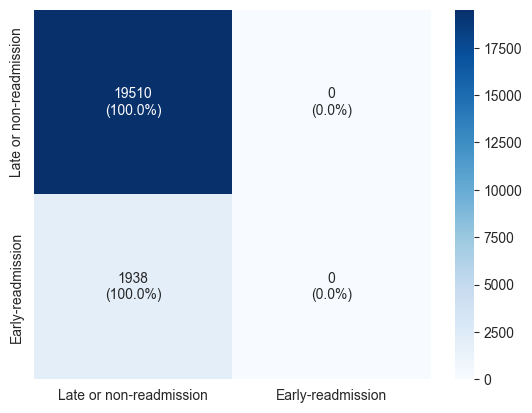

In [24]:
# Visualize confusion matrix with both absolute and percentage values
cm_none = confusion_matrix(y_test, y_test_pred_none)
cm_none_norm = confusion_matrix(y_test, y_test_pred_none, normalize='true')

annotations_none = np.array([
    [f"{val}\n({perc:.1%})" for val, perc in zip(row, norm_row)]
    for row, norm_row in zip(cm_none, cm_none_norm)
])

sns.heatmap(
    cm_none,
    annot=annotations_none,
    cmap='Blues',
    fmt='',
    xticklabels=['Late or non-readmission', 'Early-readmission'],
    yticklabels=['Late or non-readmission', 'Early-readmission']
)

## **3. Optuna Hyper-parameter Tuning | Undersampling**
Hyper-parameter tuning of the model using Optuna, and undersampling with RandomUnderSampler.

### 3.1 Objective & study setup
Preparing the objective function with all hyper-parameters, and creating/loading the Optuna study.

In [25]:
def objective(trial: optuna.Trial) -> float:
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 200),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 1.0, log=True),
        "algorithm": trial.suggest_categorical("algorithm", ["SAMME", "SAMME.R"])
    }
    
    # Build pipeline
    pipeline = make_pipeline(
        RandomUnderSampler(random_state=RANDOM_STATE),
        AdaBoostClassifier(**params, random_state=RANDOM_STATE)
    )
    
    # Define validation folds
    kf = StratifiedKFold(n_splits=5, shuffle=False)
    
    # Cross validation
    scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring=SCORING)

    print("Cross validation scores: {}".format(scores))
    print("Average score: {}".format(scores.mean()))

    return scores.mean()

In [26]:
# Set up study with name and storage
storage = JournalStorage(JournalFileBackend(STUDY_PATH_RUS))

study = optuna.create_study(
    direction="maximize",
    study_name=STUDY_NAME,
    storage=storage,
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(constant_liar=True, seed=RANDOM_STATE),
    pruner=optuna.pruners.SuccessiveHalvingPruner()
)

optuna.logging.set_verbosity(optuna.logging.INFO)

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\_experimental.py:31: ExperimentalWarning:

Argument ``constant_liar`` is an experimental feature. The interface can change in the future.

[I 2025-01-12 17:48:38,659] A new study created in Journal with name: Diabetes_130-US


### 3.2 Hyper-parameter tuning
**(CAUTION)** <u>Do not run</u>, unless you already need to find the best parameters. If you already have bound the best model configuration, <u>run the section above</u> _(Objective & study setup)_.

In [27]:
study.optimize(
    objective,
    n_trials=N_TRIALS,
    n_jobs=-1 # Use all available cores
)

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.50216243 0.50775767 0.52045237 0.50945802 0.5063975 ]
Average score: 0.50924560041786


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 17:48:44,992] Trial 5 finished with value: 0.522055784403079 and parameters: {'n_estimators': 76, 'learning_rate': 0.07685133939224548, 'algorithm': 'SAMME.R'}. Best is trial 5 with value: 0.522055784403079.


Cross validation scores: [0.51846876 0.52580087 0.52929907 0.51912778 0.51758245]
Average score: 0.522055784403079


[I 2025-01-12 17:48:45,383] Trial 4 finished with value: 0.522491618467926 and parameters: {'n_estimators': 105, 'learning_rate': 0.18507958416843628, 'algorithm': 'SAMME'}. Best is trial 4 with value: 0.522491618467926.


Cross validation scores: [0.51794541 0.52609702 0.5286155  0.51879232 0.52100784]
Average score: 0.522491618467926


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 17:48:47,016] Trial 0 finished with value: 0.5188081790125467 and parameters: {'n_estimators': 145, 'learning_rate': 0.18858658031522021, 'algorithm': 'SAMME'}. Best is trial 4 with value: 0.522491618467926.


Cross validation scores: [0.50058747 0.52556271 0.52936493 0.52004319 0.51848259]
Average score: 0.5188081790125467


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 17:48:49,411] Trial 2 finished with value: 0.516828257239421 and parameters: {'n_estimators': 198, 'learning_rate': 0.2124911074612901, 'algorithm': 'SAMME'}. Best is trial 4 with value: 0.522491618467926.


Cross validation scores: [0.50186645 0.5259497  0.529325   0.51939314 0.507607  ]
Average score: 0.516828257239421


[I 2025-01-12 17:48:50,215] Trial 6 finished with value: 0.538581560994905 and parameters: {'n_estimators': 120, 'learning_rate': 0.010584922541691848, 'algorithm': 'SAMME'}. Best is trial 6 with value: 0.538581560994905.


Cross validation scores: [0.53971764 0.53820179 0.5426661  0.53338814 0.53893412]
Average score: 0.538581560994905


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 17:48:50,574] Trial 9 finished with value: 0.5302881941737633 and parameters: {'n_estimators': 58, 'learning_rate': 0.058144761332360365, 'algorithm': 'SAMME'}. Best is trial 6 with value: 0.538581560994905.


Cross validation scores: [0.51611374 0.52462146 0.5426661  0.53491596 0.5331237 ]
Average score: 0.5302881941737633


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 17:48:51,518] Trial 8 finished with value: 0.5221053797479862 and parameters: {'n_estimators': 109, 'learning_rate': 0.1481544523368304, 'algorithm': 'SAMME'}. Best is trial 6 with value: 0.538581560994905.


Cross validation scores: [0.51729217 0.52557498 0.52875291 0.517899   0.52100784]
Average score: 0.5221053797479862
Cross validation scores: [0.51611374 0.52462146 0.54553079 0.53491596 0.5331237 ]
Average score: 0.5308611323602781
Cross validation scores: [0.51611374 0.52462146 0.52574643 0.51595657 0.51290396]
Average score: 0.5190684338088966


[I 2025-01-12 17:48:51,688] Trial 7 finished with value: 0.5308611323602781 and parameters: {'n_estimators': 114, 'learning_rate': 0.03790286998599051, 'algorithm': 'SAMME'}. Best is trial 6 with value: 0.538581560994905.
[I 2025-01-12 17:48:51,815] Trial 1 finished with value: 0.5190684338088966 and parameters: {'n_estimators': 183, 'learning_rate': 0.014623503924285556, 'algorithm': 'SAMME.R'}. Best is trial 6 with value: 0.538581560994905.
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.ven

Cross validation scores: [0.51611374 0.52462146 0.53558758 0.51595657 0.51290396]
Average score: 0.5210366631069755
Cross validation scores: [0.51611374 0.52462146 0.53558758 0.51595657 0.53067807]
Average score: 0.524591483344462
Cross validation scores: [0.51611374 0.52462146 0.54553079 0.51595657 0.5331237 ]
Average score: 0.5270692535252802


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 17:48:53,268] Trial 12 finished with value: 0.5270692535252802 and parameters: {'n_estimators': 51, 'learning_rate': 0.09819775723877003, 'algorithm': 'SAMME'}. Best is trial 6 with value: 0.538581560994905.
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 17

Cross validation scores: [0.50999974 0.52615024 0.52918426 0.51953079 0.51037055]
Average score: 0.519047117471977


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 17:48:58,016] Trial 13 finished with value: 0.510847264431268 and parameters: {'n_estimators': 103, 'learning_rate': 0.14380370108228832, 'algorithm': 'SAMME.R'}. Best is trial 6 with value: 0.538581560994905.


Cross validation scores: [0.50314688 0.50950568 0.52257022 0.5118442  0.50716934]
Average score: 0.510847264431268


[I 2025-01-12 17:48:59,972] Trial 15 finished with value: 0.538581560994905 and parameters: {'n_estimators': 156, 'learning_rate': 0.011474093655991415, 'algorithm': 'SAMME'}. Best is trial 6 with value: 0.538581560994905.


Cross validation scores: [0.53971764 0.53820179 0.5426661  0.53338814 0.53893412]
Average score: 0.538581560994905


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 17:49:00,265] Trial 18 finished with value: 0.5308611323602781 and parameters: {'n_estimators': 123, 'learning_rate': 0.039868525870916056, 'algorithm': 'SAMME'}. Best is trial 6 with value: 0.538581560994905.


Cross validation scores: [0.51611374 0.52462146 0.54553079 0.53491596 0.5331237 ]
Average score: 0.5308611323602781


[I 2025-01-12 17:49:00,940] Trial 17 finished with value: 0.5302881941737633 and parameters: {'n_estimators': 137, 'learning_rate': 0.025869713870006753, 'algorithm': 'SAMME'}. Best is trial 6 with value: 0.538581560994905.


Cross validation scores: [0.51611374 0.52462146 0.5426661  0.53491596 0.5331237 ]
Average score: 0.5302881941737633


[I 2025-01-12 17:49:01,241] Trial 16 finished with value: 0.5302881941737633 and parameters: {'n_estimators': 142, 'learning_rate': 0.027951675701941434, 'algorithm': 'SAMME'}. Best is trial 6 with value: 0.538581560994905.


Cross validation scores: [0.51611374 0.52462146 0.5426661  0.53491596 0.5331237 ]
Average score: 0.5302881941737633


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 17:49:03,020] Trial 20 finished with value: 0.5302881941737633 and parameters: {'n_estimators': 88, 'learning_rate': 0.04405816002183849, 'algorithm': 'SAMME'}. Best is trial 6 with value: 0.538581560994905.


Cross validation scores: [0.51611374 0.52462146 0.5426661  0.53491596 0.5331237 ]
Average score: 0.5302881941737633


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 17:49:04,024] Trial 19 finished with value: 0.5302881941737633 and parameters: {'n_estimators': 174, 'learning_rate': 0.020486622911230278, 'algorithm': 'SAMME'}. Best is trial 6 with value: 0.538581560994905.


Cross validation scores: [0.51611374 0.52462146 0.5426661  0.53491596 0.5331237 ]
Average score: 0.5302881941737633


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 17:49:04,996] Trial 25 finished with value: 0.533860780923925 and parameters: {'n_estimators': 25, 'learning_rate': 0.015426053705329307, 'algorithm': 'SAMME.R'}. Best is trial 6 with value: 0.538581560994905.


Cross validation scores: [0.51611374 0.53820179 0.5426661  0.53338814 0.53893412]
Average score: 0.533860780923925


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.53971764 0.53820179 0.5426661  0.53338814 0.53893412]
Average score: 0.538581560994905


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 17:49:07,599] Trial 23 finished with value: 0.533860780923925 and parameters: {'n_estimators': 124, 'learning_rate': 0.017935048334451927, 'algorithm': 'SAMME'}. Best is trial 6 with value: 0.538581560994905.


Cross validation scores: [0.51611374 0.53820179 0.5426661  0.53338814 0.53893412]
Average score: 0.533860780923925


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 17:49:08,449] Trial 22 finished with value: 0.538581560994905 and parameters: {'n_estimators': 158, 'learning_rate': 0.01155618280144699, 'algorithm': 'SAMME'}. Best is trial 6 with value: 0.538581560994905.


Cross validation scores: [0.53971764 0.53820179 0.5426661  0.53338814 0.53893412]
Average score: 0.538581560994905


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 17:49:10,498] Trial 26 finished with value: 0.5302881941737633 and parameters: {'n_estimators': 123, 'learning_rate': 0.029671386436455206, 'algorithm': 'SAMME'}. Best is trial 6 with value: 0.538581560994905.


Cross validation scores: [0.51611374 0.52462146 0.5426661  0.53491596 0.5331237 ]
Average score: 0.5302881941737633
Cross validation scores: [0.51611374 0.52462146 0.52574643 0.51595657 0.51290396]
Average score: 0.5190684338088966


[I 2025-01-12 17:49:10,674] Trial 21 finished with value: 0.5190684338088966 and parameters: {'n_estimators': 165, 'learning_rate': 0.010846771768075096, 'algorithm': 'SAMME.R'}. Best is trial 6 with value: 0.538581560994905.
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 17:49:11,448] Trial 24 finished with value: 0.5090343451079404 and parameters: {'n_estimators': 199, 'learning_rate': 0.6171627751854984, 'algorithm': 'SAMME'}. Best is trial 6 with value: 0.538581560994905.


Cross validation scores: [0.49696593 0.50431086 0.52571919 0.51204352 0.50613222]
Average score: 0.5090343451079404


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.51611374 0.52462146 0.52574643 0.51595657 0.51290396]
Average score: 0.5190684338088966
Cross validation scores: [0.53971764 0.53820179 0.5426661  0.53338814 0.53893412]
Average score: 0.538581560994905
Cross validation scores: [0.51611374 0.52462146 0.52635088 0.51595657 0.51290396]
Average score: 0.5191893236156672


[I 2025-01-12 17:49:16,349] Trial 29 finished with value: 0.5191893236156672 and parameters: {'n_estimators': 140, 'learning_rate': 0.02101307270051595, 'algorithm': 'SAMME.R'}. Best is trial 6 with value: 0.538581560994905.
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Wor

Cross validation scores: [0.51611374 0.52462146 0.53558758 0.51595657 0.53067807]
Average score: 0.524591483344462


[I 2025-01-12 17:49:18,899] Trial 34 finished with value: 0.5299826302604684 and parameters: {'n_estimators': 35, 'learning_rate': 0.01379120075549477, 'algorithm': 'SAMME.R'}. Best is trial 6 with value: 0.538581560994905.


Cross validation scores: [0.51611374 0.52462146 0.5426661  0.53338814 0.5331237 ]
Average score: 0.5299826302604684


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 17:49:19,741] Trial 31 finished with value: 0.533860780923925 and parameters: {'n_estimators': 182, 'learning_rate': 0.013160614009828682, 'algorithm': 'SAMME'}. Best is trial 6 with value: 0.538581560994905.


Cross validation scores: [0.51611374 0.53820179 0.5426661  0.53338814 0.53893412]
Average score: 0.533860780923925


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 17:49:20,816] Trial 33 finished with value: 0.5119594979229698 and parameters: {'n_estimators': 186, 'learning_rate': 0.3759973448113408, 'algorithm': 'SAMME'}. Best is trial 6 with value: 0.538581560994905.


Cross validation scores: [0.49970925 0.51071691 0.52783881 0.5139341  0.50759841]
Average score: 0.5119594979229698


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 17:49:22,724] Trial 36 finished with value: 0.5190684338088966 and parameters: {'n_estimators': 93, 'learning_rate': 0.01735152436890564, 'algorithm': 'SAMME.R'}. Best is trial 6 with value: 0.538581560994905.


Cross validation scores: [0.51611374 0.52462146 0.52574643 0.51595657 0.51290396]
Average score: 0.5190684338088966


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 17:49:25,031] Trial 35 finished with value: 0.5190684338088966 and parameters: {'n_estimators': 131, 'learning_rate': 0.016755215541431823, 'algorithm': 'SAMME.R'}. Best is trial 6 with value: 0.538581560994905.


Cross validation scores: [0.51611374 0.52462146 0.52574643 0.51595657 0.51290396]
Average score: 0.5190684338088966


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 17:49:27,100] Trial 40 finished with value: 0.538581560994905 and parameters: {'n_estimators': 116, 'learning_rate': 0.010247845866471799, 'algorithm': 'SAMME'}. Best is trial 6 with value: 0.538581560994905.


Cross validation scores: [0.53971764 0.53820179 0.5426661  0.53338814 0.53893412]
Average score: 0.538581560994905


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 17:49:27,367] Trial 37 finished with value: 0.533860780923925 and parameters: {'n_estimators': 170, 'learning_rate': 0.012765553287956668, 'algorithm': 'SAMME'}. Best is trial 6 with value: 0.538581560994905.


Cross validation scores: [0.51611374 0.53820179 0.5426661  0.53338814 0.53893412]
Average score: 0.533860780923925


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 17:49:27,894] Trial 41 finished with value: 0.533860780923925 and parameters: {'n_estimators': 96, 'learning_rate': 0.019950661892573926, 'algorithm': 'SAMME'}. Best is trial 6 with value: 0.538581560994905.


Cross validation scores: [0.51611374 0.53820179 0.5426661  0.53338814 0.53893412]
Average score: 0.533860780923925


[I 2025-01-12 17:49:28,397] Trial 38 finished with value: 0.5205277693511748 and parameters: {'n_estimators': 149, 'learning_rate': 0.0247344601018683, 'algorithm': 'SAMME.R'}. Best is trial 6 with value: 0.538581560994905.


Cross validation scores: [0.51611374 0.52510744 0.52743614 0.51763855 0.51634298]
Average score: 0.5205277693511748


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 17:49:29,443] Trial 39 finished with value: 0.5270692535252802 and parameters: {'n_estimators': 188, 'learning_rate': 0.033063585433002564, 'algorithm': 'SAMME'}. Best is trial 6 with value: 0.538581560994905.


Cross validation scores: [0.51611374 0.52462146 0.54553079 0.51595657 0.5331237 ]
Average score: 0.5270692535252802


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 17:49:29,816] Trial 43 finished with value: 0.538581560994905 and parameters: {'n_estimators': 46, 'learning_rate': 0.013161186574915133, 'algorithm': 'SAMME'}. Best is trial 6 with value: 0.538581560994905.


Cross validation scores: [0.53971764 0.53820179 0.5426661  0.53338814 0.53893412]
Average score: 0.538581560994905


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 17:49:32,923] Trial 44 finished with value: 0.5190684338088966 and parameters: {'n_estimators': 85, 'learning_rate': 0.02252426164892475, 'algorithm': 'SAMME.R'}. Best is trial 6 with value: 0.538581560994905.


Cross validation scores: [0.51611374 0.52462146 0.52574643 0.51595657 0.51290396]
Average score: 0.5190684338088966


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 17:49:35,222] Trial 42 finished with value: 0.5151746751341063 and parameters: {'n_estimators': 162, 'learning_rate': 0.05169323099393764, 'algorithm': 'SAMME.R'}. Best is trial 6 with value: 0.538581560994905.


Cross validation scores: [0.50838368 0.51003911 0.52830276 0.51998895 0.50915886]
Average score: 0.5151746751341063


[I 2025-01-12 17:49:35,731] Trial 45 finished with value: 0.533860780923925 and parameters: {'n_estimators': 148, 'learning_rate': 0.014955882640068162, 'algorithm': 'SAMME'}. Best is trial 6 with value: 0.538581560994905.


Cross validation scores: [0.51611374 0.53820179 0.5426661  0.53338814 0.53893412]
Average score: 0.533860780923925


[I 2025-01-12 17:49:36,498] Trial 47 finished with value: 0.538581560994905 and parameters: {'n_estimators': 133, 'learning_rate': 0.010016543642527498, 'algorithm': 'SAMME'}. Best is trial 6 with value: 0.538581560994905.


Cross validation scores: [0.53971764 0.53820179 0.5426661  0.53338814 0.53893412]
Average score: 0.538581560994905


[I 2025-01-12 17:49:37,600] Trial 46 finished with value: 0.533860780923925 and parameters: {'n_estimators': 176, 'learning_rate': 0.010617425106903174, 'algorithm': 'SAMME'}. Best is trial 6 with value: 0.538581560994905.


Cross validation scores: [0.51611374 0.53820179 0.5426661  0.53338814 0.53893412]
Average score: 0.533860780923925


[I 2025-01-12 17:49:37,999] Trial 48 finished with value: 0.533860780923925 and parameters: {'n_estimators': 152, 'learning_rate': 0.014532573177847766, 'algorithm': 'SAMME'}. Best is trial 6 with value: 0.538581560994905.


Cross validation scores: [0.51611374 0.53820179 0.5426661  0.53338814 0.53893412]
Average score: 0.533860780923925


[I 2025-01-12 17:49:39,428] Trial 50 finished with value: 0.538581560994905 and parameters: {'n_estimators': 71, 'learning_rate': 0.011695583622200807, 'algorithm': 'SAMME'}. Best is trial 6 with value: 0.538581560994905.


Cross validation scores: [0.53971764 0.53820179 0.5426661  0.53338814 0.53893412]
Average score: 0.538581560994905


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 17:49:41,233] Trial 53 finished with value: 0.5226051433240806 and parameters: {'n_estimators': 61, 'learning_rate': 0.27748392882075945, 'algorithm': 'SAMME'}. Best is trial 6 with value: 0.538581560994905.


Cross validation scores: [0.51807618 0.52557498 0.52895936 0.51940735 0.52100784]
Average score: 0.5226051433240806


[I 2025-01-12 17:49:41,509] Trial 49 finished with value: 0.502395720341017 and parameters: {'n_estimators': 161, 'learning_rate': 0.9463615687297348, 'algorithm': 'SAMME'}. Best is trial 6 with value: 0.538581560994905.


Cross validation scores: [0.49906791 0.49996349 0.5077211  0.50306367 0.50216243]
Average score: 0.502395720341017


[I 2025-01-12 17:49:41,767] Trial 51 finished with value: 0.533860780923925 and parameters: {'n_estimators': 110, 'learning_rate': 0.017950446789935032, 'algorithm': 'SAMME'}. Best is trial 6 with value: 0.538581560994905.


Cross validation scores: [0.51611374 0.53820179 0.5426661  0.53338814 0.53893412]
Average score: 0.533860780923925


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 17:49:46,456] Trial 55 finished with value: 0.5190684338088966 and parameters: {'n_estimators': 103, 'learning_rate': 0.024948069449265448, 'algorithm': 'SAMME.R'}. Best is trial 6 with value: 0.538581560994905.


Cross validation scores: [0.51611374 0.52462146 0.52574643 0.51595657 0.51290396]
Average score: 0.5190684338088966


[I 2025-01-12 17:49:46,716] Trial 52 finished with value: 0.5270692535252802 and parameters: {'n_estimators': 192, 'learning_rate': 0.03180744987473735, 'algorithm': 'SAMME'}. Best is trial 6 with value: 0.538581560994905.


Cross validation scores: [0.51611374 0.52462146 0.54553079 0.51595657 0.5331237 ]
Average score: 0.5270692535252802


[I 2025-01-12 17:49:47,193] Trial 54 finished with value: 0.524591483344462 and parameters: {'n_estimators': 170, 'learning_rate': 0.07211220169733647, 'algorithm': 'SAMME'}. Best is trial 6 with value: 0.538581560994905.


Cross validation scores: [0.51611374 0.52462146 0.53558758 0.51595657 0.53067807]
Average score: 0.524591483344462


[I 2025-01-12 17:49:47,475] Trial 56 finished with value: 0.538581560994905 and parameters: {'n_estimators': 116, 'learning_rate': 0.011809375141318208, 'algorithm': 'SAMME'}. Best is trial 6 with value: 0.538581560994905.


Cross validation scores: [0.53971764 0.53820179 0.5426661  0.53338814 0.53893412]
Average score: 0.538581560994905


[I 2025-01-12 17:49:48,164] Trial 58 finished with value: 0.533860780923925 and parameters: {'n_estimators': 118, 'learning_rate': 0.015988536837578428, 'algorithm': 'SAMME'}. Best is trial 6 with value: 0.538581560994905.


Cross validation scores: [0.51611374 0.53820179 0.5426661  0.53338814 0.53893412]
Average score: 0.533860780923925


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 17:49:48,449] Trial 57 finished with value: 0.538581560994905 and parameters: {'n_estimators': 131, 'learning_rate': 0.01038666876070962, 'algorithm': 'SAMME'}. Best is trial 6 with value: 0.538581560994905.


Cross validation scores: [0.53971764 0.53820179 0.5426661  0.53338814 0.53893412]
Average score: 0.538581560994905


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.53971764 0.53820179 0.5426661  0.53338814 0.53893412]
Average score: 0.538581560994905


[I 2025-01-12 17:49:51,387] Trial 65 finished with value: 0.538581560994905 and parameters: {'n_estimators': 26, 'learning_rate': 0.015545596347707021, 'algorithm': 'SAMME'}. Best is trial 6 with value: 0.538581560994905.


Cross validation scores: [0.53971764 0.53820179 0.5426661  0.53338814 0.53893412]
Average score: 0.538581560994905


[I 2025-01-12 17:49:53,598] Trial 62 finished with value: 0.533860780923925 and parameters: {'n_estimators': 107, 'learning_rate': 0.01982737554196919, 'algorithm': 'SAMME'}. Best is trial 6 with value: 0.538581560994905.
[I 2025-01-12 17:49:53,692] Trial 60 finished with value: 0.5214703455796124 and parameters: {'n_estimators': 126, 'learning_rate': 0.11925601249646121, 'algorithm': 'SAMME'}. Best is trial 6 with value: 0.538581560994905.


Cross validation scores: [0.51611374 0.53820179 0.5426661  0.53338814 0.53893412]
Average score: 0.533860780923925
Cross validation scores: [0.51643937 0.52510744 0.52800378 0.5167933  0.52100784]
Average score: 0.5214703455796124


[I 2025-01-12 17:49:54,226] Trial 66 finished with value: 0.538581560994905 and parameters: {'n_estimators': 47, 'learning_rate': 0.01274223765825035, 'algorithm': 'SAMME'}. Best is trial 6 with value: 0.538581560994905.


Cross validation scores: [0.53971764 0.53820179 0.5426661  0.53338814 0.53893412]
Average score: 0.538581560994905
Cross validation scores: [0.51611374 0.53820179 0.5426661  0.53338814 0.53893412]
Average score: 0.533860780923925


[I 2025-01-12 17:49:54,452] Trial 59 finished with value: 0.533860780923925 and parameters: {'n_estimators': 144, 'learning_rate': 0.013980900762766126, 'algorithm': 'SAMME'}. Best is trial 6 with value: 0.538581560994905.
[I 2025-01-12 17:49:54,738] Trial 61 finished with value: 0.538581560994905 and parameters: {'n_estimators': 138, 'learning_rate': 0.010024915397122995, 'algorithm': 'SAMME'}. Best is trial 6 with value: 0.538581560994905.


Cross validation scores: [0.53971764 0.53820179 0.5426661  0.53338814 0.53893412]
Average score: 0.538581560994905


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 17:49:55,156] Trial 67 finished with value: 0.538581560994905 and parameters: {'n_estimators': 20, 'learning_rate': 0.0122027013273518, 'algorithm': 'SAMME'}. Best is trial 6 with value: 0.538581560994905.


Cross validation scores: [0.53971764 0.53820179 0.5426661  0.53338814 0.53893412]
Average score: 0.538581560994905


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 17:49:56,222] Trial 68 finished with value: 0.538581560994905 and parameters: {'n_estimators': 38, 'learning_rate': 0.013673867815408977, 'algorithm': 'SAMME'}. Best is trial 6 with value: 0.538581560994905.


Cross validation scores: [0.53971764 0.53820179 0.5426661  0.53338814 0.53893412]
Average score: 0.538581560994905


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 17:49:56,899] Trial 64 finished with value: 0.5299826302604684 and parameters: {'n_estimators': 155, 'learning_rate': 0.01853290001656555, 'algorithm': 'SAMME'}. Best is trial 6 with value: 0.538581560994905.


Cross validation scores: [0.51611374 0.52462146 0.5426661  0.53338814 0.5331237 ]
Average score: 0.5299826302604684


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 17:49:57,896] Trial 71 finished with value: 0.5224523680016085 and parameters: {'n_estimators': 41, 'learning_rate': 0.0163923477704886, 'algorithm': 'SAMME.R'}. Best is trial 6 with value: 0.538581560994905.
[I 2025-01-12 17:49:57,903] Trial 69 finished with value: 0.538581560994905 and parameters: {'n_estimators': 62, 'learning_rate': 0.02260581831587344, 'algorithm': 'SAMME'}. Best is trial 6 with value: 0.538581560994905.


Cross validation scores: [0.51611374 0.52462146 0.5426661  0.51595657 0.51290396]
Average score: 0.5224523680016085
Cross validation scores: [0.53971764 0.53820179 0.5426661  0.53338814 0.53893412]
Average score: 0.538581560994905


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 17:49:59,704] Trial 72 finished with value: 0.538581560994905 and parameters: {'n_estimators': 83, 'learning_rate': 0.013775501692417053, 'algorithm': 'SAMME'}. Best is trial 6 with value: 0.538581560994905.


Cross validation scores: [0.53971764 0.53820179 0.5426661  0.53338814 0.53893412]
Average score: 0.538581560994905


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 17:50:01,526] Trial 73 finished with value: 0.538581560994905 and parameters: {'n_estimators': 98, 'learning_rate': 0.011461116268726678, 'algorithm': 'SAMME'}. Best is trial 6 with value: 0.538581560994905.


Cross validation scores: [0.53971764 0.53820179 0.5426661  0.53338814 0.53893412]
Average score: 0.538581560994905


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 17:50:03,814] Trial 70 finished with value: 0.533860780923925 and parameters: {'n_estimators': 178, 'learning_rate': 0.011517939685771634, 'algorithm': 'SAMME'}. Best is trial 6 with value: 0.538581560994905.


Cross validation scores: [0.51611374 0.53820179 0.5426661  0.53338814 0.53893412]
Average score: 0.533860780923925


[I 2025-01-12 17:50:05,346] Trial 75 finished with value: 0.538581560994905 and parameters: {'n_estimators': 133, 'learning_rate': 0.010003658711944183, 'algorithm': 'SAMME'}. Best is trial 6 with value: 0.538581560994905.
[I 2025-01-12 17:50:05,350] Trial 76 finished with value: 0.538581560994905 and parameters: {'n_estimators': 135, 'learning_rate': 0.010007346763264197, 'algorithm': 'SAMME'}. Best is trial 6 with value: 0.538581560994905.


Cross validation scores: [0.53971764 0.53820179 0.5426661  0.53338814 0.53893412]
Average score: 0.538581560994905
Cross validation scores: [0.53971764 0.53820179 0.5426661  0.53338814 0.53893412]
Average score: 0.538581560994905


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 17:50:06,027] Trial 77 finished with value: 0.538581560994905 and parameters: {'n_estimators': 120, 'learning_rate': 0.012806371032939846, 'algorithm': 'SAMME'}. Best is trial 6 with value: 0.538581560994905.


Cross validation scores: [0.53971764 0.53820179 0.5426661  0.53338814 0.53893412]
Average score: 0.538581560994905


[I 2025-01-12 17:50:07,547] Trial 74 finished with value: 0.5190684338088966 and parameters: {'n_estimators': 165, 'learning_rate': 0.010000881413058485, 'algorithm': 'SAMME.R'}. Best is trial 6 with value: 0.538581560994905.


Cross validation scores: [0.51611374 0.52462146 0.52574643 0.51595657 0.51290396]
Average score: 0.5190684338088966
Cross validation scores: [0.53971764 0.53820179 0.5426661  0.53338814 0.53893412]
Average score: 0.538581560994905
Cross validation scores: [0.53971764 0.53820179 0.5426661  0.53338814 0.53893412]
Average score: 0.538581560994905


[I 2025-01-12 17:50:07,663] Trial 78 finished with value: 0.538581560994905 and parameters: {'n_estimators': 112, 'learning_rate': 0.015911831135174477, 'algorithm': 'SAMME'}. Best is trial 6 with value: 0.538581560994905.
[I 2025-01-12 17:50:07,664] Trial 81 finished with value: 0.538581560994905 and parameters: {'n_estimators': 29, 'learning_rate': 0.011500602754829996, 'algorithm': 'SAMME'}. Best is trial 6 with value: 0.538581560994905.
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\

Cross validation scores: [0.53971764 0.53820179 0.5426661  0.53338814 0.53893412]
Average score: 0.538581560994905


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 17:50:09,907] Trial 79 finished with value: 0.533860780923925 and parameters: {'n_estimators': 126, 'learning_rate': 0.018530971292897047, 'algorithm': 'SAMME'}. Best is trial 6 with value: 0.538581560994905.


Cross validation scores: [0.51611374 0.53820179 0.5426661  0.53338814 0.53893412]
Average score: 0.533860780923925


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.



Cross validation scores: [0.51611374 0.53820179 0.5426661  0.53338814 0.53893412]
Average score: 0.533860780923925
Cross validation scores: [0.53971764 0.53820179 0.5426661  0.53338814 0.53893412]
Average score: 0.538581560994905


[I 2025-01-12 17:50:13,064] Trial 80 finished with value: 0.533860780923925 and parameters: {'n_estimators': 146, 'learning_rate': 0.014722706138503213, 'algorithm': 'SAMME'}. Best is trial 6 with value: 0.538581560994905.
[I 2025-01-12 17:50:13,067] Trial 87 finished with value: 0.538581560994905 and parameters: {'n_estimators': 51, 'learning_rate': 0.01120668591908049, 'algorithm': 'SAMME'}. Best is trial 6 with value: 0.538581560994905.
[I 2025-01-12 17:50:13,211] Trial 86 finished with value: 0.538581560994905 and parameters: {'n_estimators': 72, 'learning_rate': 0.011140299988835714, 'algorithm': 'SAMME'}. Best is trial 6 with value: 0.538581560994905.
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.



Cross validation scores: [0.53971764 0.53820179 0.5426661  0.53338814 0.53893412]
Average score: 0.538581560994905
Cross validation scores: [0.51611374 0.52462146 0.5426661  0.53491596 0.5331237 ]
Average score: 0.5302881941737633


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 17:50:13,503] Trial 82 finished with value: 0.5302881941737633 and parameters: {'n_estimators': 152, 'learning_rate': 0.022255279679542807, 'algorithm': 'SAMME'}. Best is trial 6 with value: 0.538581560994905.
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 

Cross validation scores: [0.51611374 0.52462146 0.52574643 0.51595657 0.51290396]
Average score: 0.5190684338088966
Cross validation scores: [0.51611374 0.52462146 0.52574643 0.51595657 0.51290396]
Average score: 0.5190684338088966


[I 2025-01-12 17:50:16,890] Trial 91 finished with value: 0.538581560994905 and parameters: {'n_estimators': 55, 'learning_rate': 0.015415731913677358, 'algorithm': 'SAMME'}. Best is trial 6 with value: 0.538581560994905.


Cross validation scores: [0.53971764 0.53820179 0.5426661  0.53338814 0.53893412]
Average score: 0.538581560994905


[I 2025-01-12 17:50:17,118] Trial 90 finished with value: 0.538581560994905 and parameters: {'n_estimators': 66, 'learning_rate': 0.011820949827623065, 'algorithm': 'SAMME'}. Best is trial 6 with value: 0.538581560994905.


Cross validation scores: [0.53971764 0.53820179 0.5426661  0.53338814 0.53893412]
Average score: 0.538581560994905


[I 2025-01-12 17:50:19,948] Trial 94 finished with value: 0.538581560994905 and parameters: {'n_estimators': 45, 'learning_rate': 0.020268086243624625, 'algorithm': 'SAMME'}. Best is trial 6 with value: 0.538581560994905.


Cross validation scores: [0.53971764 0.53820179 0.5426661  0.53338814 0.53893412]
Average score: 0.538581560994905


[I 2025-01-12 17:50:21,784] Trial 89 finished with value: 0.5299826302604684 and parameters: {'n_estimators': 160, 'learning_rate': 0.017357877556581452, 'algorithm': 'SAMME'}. Best is trial 6 with value: 0.538581560994905.
[I 2025-01-12 17:50:21,788] Trial 88 finished with value: 0.5299826302604684 and parameters: {'n_estimators': 160, 'learning_rate': 0.016554898942276092, 'algorithm': 'SAMME'}. Best is trial 6 with value: 0.538581560994905.


Cross validation scores: [0.51611374 0.52462146 0.5426661  0.53338814 0.5331237 ]
Average score: 0.5299826302604684
Cross validation scores: [0.51611374 0.52462146 0.5426661  0.53338814 0.5331237 ]
Average score: 0.5299826302604684
Cross validation scores: [0.51611374 0.52462146 0.5426661  0.53491596 0.5331237 ]
Average score: 0.5302881941737633


[I 2025-01-12 17:50:21,950] Trial 95 finished with value: 0.5302881941737633 and parameters: {'n_estimators': 81, 'learning_rate': 0.03841367504907555, 'algorithm': 'SAMME'}. Best is trial 6 with value: 0.538581560994905.
[I 2025-01-12 17:50:22,260] Trial 92 finished with value: 0.5228474643688582 and parameters: {'n_estimators': 103, 'learning_rate': 0.1802483020998536, 'algorithm': 'SAMME'}. Best is trial 6 with value: 0.538581560994905.


Cross validation scores: [0.51835601 0.52609702 0.52868274 0.52009372 0.52100784]
Average score: 0.5228474643688582


[I 2025-01-12 17:50:24,189] Trial 99 finished with value: 0.538581560994905 and parameters: {'n_estimators': 32, 'learning_rate': 0.012311101880239466, 'algorithm': 'SAMME'}. Best is trial 6 with value: 0.538581560994905.


Cross validation scores: [0.53971764 0.53820179 0.5426661  0.53338814 0.53893412]
Average score: 0.538581560994905


[I 2025-01-12 17:50:24,980] Trial 93 finished with value: 0.533860780923925 and parameters: {'n_estimators': 171, 'learning_rate': 0.012442800966159732, 'algorithm': 'SAMME'}. Best is trial 6 with value: 0.538581560994905.
[I 2025-01-12 17:50:24,983] Trial 96 finished with value: 0.538581560994905 and parameters: {'n_estimators': 116, 'learning_rate': 0.011730884204548866, 'algorithm': 'SAMME'}. Best is trial 6 with value: 0.538581560994905.


Cross validation scores: [0.51611374 0.53820179 0.5426661  0.53338814 0.53893412]
Average score: 0.533860780923925
Cross validation scores: [0.53971764 0.53820179 0.5426661  0.53338814 0.53893412]
Average score: 0.538581560994905


[I 2025-01-12 17:50:26,336] Trial 97 finished with value: 0.538581560994905 and parameters: {'n_estimators': 128, 'learning_rate': 0.01088207706669214, 'algorithm': 'SAMME'}. Best is trial 6 with value: 0.538581560994905.
[I 2025-01-12 17:50:26,337] Trial 98 finished with value: 0.538581560994905 and parameters: {'n_estimators': 121, 'learning_rate': 0.015023045208818772, 'algorithm': 'SAMME'}. Best is trial 6 with value: 0.538581560994905.


Cross validation scores: [0.53971764 0.53820179 0.5426661  0.53338814 0.53893412]
Average score: 0.538581560994905
Cross validation scores: [0.53971764 0.53820179 0.5426661  0.53338814 0.53893412]
Average score: 0.538581560994905


In [28]:
print('Best Trial: {}'.format(study.best_trial.number))
print('Best Parameters: {}'.format(study.best_params))
print('Best Value: {}'.format(study.best_value))

Best Trial: 6
Best Parameters: {'n_estimators': 120, 'learning_rate': 0.010584922541691848, 'algorithm': 'SAMME'}
Best Value: 0.538581560994905


### 3.3 Optuna Visualizations
Visualizing hyper-parameter tuning results obtained by running Optuna.

In [29]:
optuna.visualization.plot_optimization_history(study)

In [30]:
optuna.visualization.plot_slice(study)

In [31]:
optuna.visualization.plot_param_importances(study)

In [32]:
optuna.visualization.plot_parallel_coordinate(study)

In [33]:
optuna.visualization.plot_contour(study)

In [34]:
optuna.visualization.plot_timeline(study)

### 3.4 Fitting Best Model
Fitting the final model using the best hyper-parameters found by Optuna.

In [35]:
# Fit best model on the training set
best_params = study.best_params

# Ensure the solver is compatible with the penalty
if best_params.get("penalty") == "elasticnet":
    best_params["solver"] = "saga"

pipeline_rus = make_pipeline(
    RandomUnderSampler(random_state=RANDOM_STATE),
    AdaBoostClassifier(**best_params, random_state=RANDOM_STATE)
)

pipeline_rus.fit(X_train, y_train)

Pipeline(steps=[('randomundersampler', RandomUnderSampler(random_state=38)),
                ('adaboostclassifier',
                 AdaBoostClassifier(algorithm='SAMME',
                                    learning_rate=0.010584922541691848,
                                    n_estimators=120, random_state=38))])

In [36]:
# Predictions
y_train_pred_rus = pipeline_rus.predict(X_train)
y_test_pred_rus = pipeline_rus.predict(X_test)

In [37]:
ac_train_rus = accuracy_score(y_train, y_train_pred_rus)
ac_test_rus = accuracy_score(y_test, y_test_pred_rus)

print('Train accuracy: ', ac_train_rus)
print('Test accuracy: ', ac_test_rus)

Train accuracy:  0.7748826056549106
Test accuracy:  0.7703282357329355


In [38]:
# Visualize precision, recall, F1-score
print(classification_report(
    y_test, y_test_pred_rus,
    target_names=['Late or non-readmission', 'Early-readmission']
))

                         precision    recall  f1-score   support

Late or non-readmission       0.92      0.81      0.87     19510
      Early-readmission       0.15      0.33      0.21      1938

               accuracy                           0.77     21448
              macro avg       0.54      0.57      0.54     21448
           weighted avg       0.85      0.77      0.81     21448



In [39]:
# Compute precision, recall, F1-score, ROC-AUC-score, and accuracy
recall_rus = recall_score(y_test, y_test_pred_rus, average='macro')
precision_rus = precision_score(y_test, y_test_pred_rus, average='macro')
f1_rus = f1_score(y_test, y_test_pred_rus, average='macro')
roc_auc_rus = roc_auc_score(y_test, y_test_pred_rus, average='macro')
accuracy_rus = accuracy_score(y_test, y_test_pred_rus)

<Axes: >

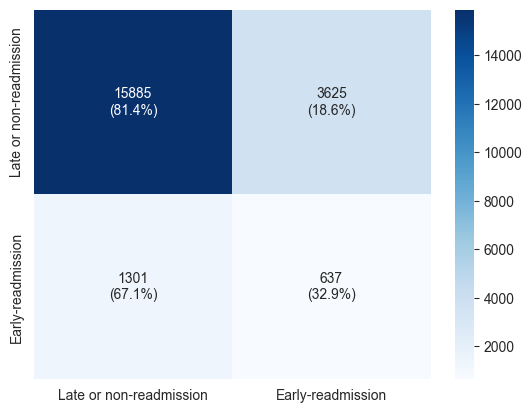

In [40]:
# Visualize confusion matrix with both absolute and percentage values
cm_rus = confusion_matrix(y_test, y_test_pred_rus)
cm_rus_norm = confusion_matrix(y_test, y_test_pred_rus, normalize='true')

annotations_rus = np.array([
    [f"{val}\n({perc:.1%})" for val, perc in zip(row, norm_row)]
    for row, norm_row in zip(cm_rus, cm_rus_norm)
])

sns.heatmap(
    cm_rus,
    annot=annotations_rus,
    cmap='Blues',
    fmt='',
    xticklabels=['Late or non-readmission', 'Early-readmission'],
    yticklabels=['Late or non-readmission', 'Early-readmission']
)

## **4. Optuna Hyper-parameter Tuning | SMOTE**
Hyper-parameter tuning of the model using Optuna, and oversampling with SMOTE.

### 4.1 Objective & study setup
Preparing the objective function with all hyper-parameters, and creating/loading the Optuna study.

In [41]:
def objective(trial: optuna.Trial) -> float:
    # Hyperparameter search space
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 200),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 1.0, log=True),
        "algorithm": trial.suggest_categorical("algorithm", ["SAMME", "SAMME.R"])
    }
    
    # Build pipeline
    pipeline = make_pipeline(
        SMOTE(random_state=RANDOM_STATE),
        AdaBoostClassifier(**params, random_state=RANDOM_STATE)
    )
    
    # Define validation folds
    kf = StratifiedKFold(n_splits=5, shuffle=False)
    
    # Cross validation
    scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring=SCORING)

    print("Cross validation scores: {}".format(scores))
    print("Average score: {}".format(scores.mean()))

    return scores.mean()

In [42]:
# Set up study with name and storage
storage = JournalStorage(JournalFileBackend(STUDY_PATH_SMOTE))

study = optuna.create_study(
    direction="maximize",
    study_name=STUDY_NAME,
    storage=storage,
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(constant_liar=True, seed=RANDOM_STATE),
    pruner=optuna.pruners.SuccessiveHalvingPruner()
)

optuna.logging.set_verbosity(optuna.logging.INFO)

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\_experimental.py:31: ExperimentalWarning:

Argument ``constant_liar`` is an experimental feature. The interface can change in the future.

[I 2025-01-12 17:50:28,182] A new study created in Journal with name: Diabetes_130-US


### 4.2 Hyper-parameter tuning
**(CAUTION)** <u>Do not run</u>, unless you already need to find the best parameters. If you already have bound the best model configuration, <u>run the section above</u> _(Objective & study setup)_.

In [43]:
study.optimize(
    objective,
    n_trials=N_TRIALS,
    n_jobs=-1 # Use all available cores
)

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.21906585 0.21784363 0.22125303 0.21919042 0.21802969]
Average score: 0.21907652201463526


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 17:50:49,588] Trial 3 finished with value: 0.38202192590654527 and parameters: {'n_estimators': 85, 'learning_rate': 0.056627659470898116, 'algorithm': 'SAMME'}. Best is trial 3 with value: 0.38202192590654527.


Cross validation scores: [0.39625568 0.35952164 0.3822389  0.36602234 0.40607107]
Average score: 0.38202192590654527


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 17:50:53,706] Trial 2 finished with value: 0.4876760060978274 and parameters: {'n_estimators': 89, 'learning_rate': 0.19247600699725087, 'algorithm': 'SAMME.R'}. Best is trial 2 with value: 0.4876760060978274.


Cross validation scores: [0.48867045 0.48887895 0.48724698 0.4873458  0.48623785]
Average score: 0.4876760060978274


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 17:51:03,196] Trial 5 finished with value: 0.43998915375698483 and parameters: {'n_estimators': 120, 'learning_rate': 0.020416943349620225, 'algorithm': 'SAMME.R'}. Best is trial 2 with value: 0.4876760060978274.


Cross validation scores: [0.45165311 0.43483907 0.439002   0.43213991 0.44231168]
Average score: 0.43998915375698483


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 17:51:09,936] Trial 7 finished with value: 0.44406023416174484 and parameters: {'n_estimators': 87, 'learning_rate': 0.17839762333327497, 'algorithm': 'SAMME'}. Best is trial 2 with value: 0.4876760060978274.


Cross validation scores: [0.44746556 0.45420554 0.44325258 0.42072923 0.45464827]
Average score: 0.44406023416174484


[I 2025-01-12 17:51:11,755] Trial 1 finished with value: 0.21907652201463526 and parameters: {'n_estimators': 190, 'learning_rate': 0.013762978900224907, 'algorithm': 'SAMME'}. Best is trial 2 with value: 0.4876760060978274.


Cross validation scores: [0.21906585 0.21784363 0.22125303 0.21919042 0.21802969]
Average score: 0.21907652201463526


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 17:51:13,971] Trial 8 finished with value: 0.458817931203609 and parameters: {'n_estimators': 87, 'learning_rate': 0.2154718498456756, 'algorithm': 'SAMME'}. Best is trial 2 with value: 0.4876760060978274.


Cross validation scores: [0.45764394 0.45994913 0.4650755  0.4532196  0.45820149]
Average score: 0.458817931203609


[I 2025-01-12 17:51:19,443] Trial 4 finished with value: 0.4378131711397648 and parameters: {'n_estimators': 181, 'learning_rate': 0.011564013194837647, 'algorithm': 'SAMME.R'}. Best is trial 2 with value: 0.4876760060978274.


Cross validation scores: [0.44875304 0.43396052 0.43928772 0.44545514 0.42160944]
Average score: 0.4378131711397648


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 17:51:28,084] Trial 6 finished with value: 0.35537242232130256 and parameters: {'n_estimators': 181, 'learning_rate': 0.02292126123661548, 'algorithm': 'SAMME'}. Best is trial 2 with value: 0.4876760060978274.


Cross validation scores: [0.3960765  0.2654582  0.35010545 0.35990202 0.40531994]
Average score: 0.35537242232130256


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.39625568 0.33788839 0.35010545 0.35990202 0.40531891]
Average score: 0.36989409133106116


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.45768192 0.44963023 0.44581164 0.43523066 0.42831133]
Average score: 0.4433331582041501


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.47097847 0.47386618 0.48400834 0.46928015 0.47302571]
Average score: 0.474231772102334
Cross validation scores: [0.45338178 0.4699683  0.45762798 0.46472408 0.44929899]
Average score: 0.459000227121935


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.53020156 0.53242243 0.53565569 0.53242711 0.52669502]
Average score: 0.5314803616474438


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 17:51:48,744] Trial 14 finished with value: 0.4672766047547402 and parameters: {'n_estimators': 75, 'learning_rate': 0.09934896516938758, 'algorithm': 'SAMME.R'}. Best is trial 13 with value: 0.5314803616474438.


Cross validation scores: [0.46306952 0.47149568 0.47736278 0.4713681  0.45308694]
Average score: 0.4672766047547402


[I 2025-01-12 17:51:49,135] Trial 17 finished with value: 0.49194592387041836 and parameters: {'n_estimators': 19, 'learning_rate': 0.9378116567608417, 'algorithm': 'SAMME.R'}. Best is trial 13 with value: 0.5314803616474438.


Cross validation scores: [0.47415143 0.47383806 0.50753465 0.52266457 0.48154091]
Average score: 0.49194592387041836


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.48307779 0.48538237 0.4827644  0.4892096  0.48506302]
Average score: 0.4850994338506462


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 17:51:54,004] Trial 21 finished with value: 0.4793254540489911 and parameters: {'n_estimators': 14, 'learning_rate': 0.720024601138709, 'algorithm': 'SAMME.R'}. Best is trial 13 with value: 0.5314803616474438.


Cross validation scores: [0.49171857 0.50023321 0.47485943 0.46539276 0.46442331]
Average score: 0.4793254540489911


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.52834136 0.53415303 0.54869103 0.53919679 0.53276117]
Average score: 0.5366286760887107


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.49718008 0.49357903 0.4871835  0.49302024 0.48939939]
Average score: 0.4920724463367446


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.53432402 0.54843039 0.54688807 0.53649934 0.54002212]
Average score: 0.5412327888070403


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.50633717 0.49306167 0.50596873 0.49948825 0.49913148]
Average score: 0.5007974614821773


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.50355126 0.50533143 0.5079527  0.5001725  0.49623816]
Average score: 0.5026492108435183


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 17:52:21,860] Trial 18 finished with value: 0.4790464826069732 and parameters: {'n_estimators': 143, 'learning_rate': 0.08302055908115548, 'algorithm': 'SAMME.R'}. Best is trial 22 with value: 0.5412327888070403.


Cross validation scores: [0.47313674 0.48063338 0.4923586  0.47424336 0.47486033]
Average score: 0.4790464826069732


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.53100155 0.54427517 0.54571819 0.54233022 0.53525037]
Average score: 0.5397150984626506


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.51911345 0.52757884 0.5367437  0.50865325 0.50867086]
Average score: 0.5201520172251424


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.50769161 0.51217041 0.50515985 0.50397319 0.50866934]
Average score: 0.5075328798465377


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.53448583 0.54107695 0.54244422 0.53611004 0.52805972]
Average score: 0.5364353511220523


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.53788462 0.53184656 0.53976999 0.5360712  0.54024423]
Average score: 0.5371633184152209


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.52960281 0.53479604 0.54580586 0.53109289 0.52286576]
Average score: 0.5328326739450958


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 17:53:04,367] Trial 30 finished with value: 0.5403101278328697 and parameters: {'n_estimators': 141, 'learning_rate': 0.9321865246411901, 'algorithm': 'SAMME.R'}. Best is trial 22 with value: 0.5412327888070403.


Cross validation scores: [0.53411547 0.54769746 0.54181915 0.53909144 0.53882713]
Average score: 0.5403101278328697


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.46019401 0.46066556 0.46494217 0.46343956 0.4494219 ]
Average score: 0.4597326393852043


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 17:53:14,010] Trial 31 finished with value: 0.5109411590414817 and parameters: {'n_estimators': 158, 'learning_rate': 0.28297171194884996, 'algorithm': 'SAMME.R'}. Best is trial 22 with value: 0.5412327888070403.


Cross validation scores: [0.50379955 0.5141955  0.51712266 0.50791064 0.51167745]
Average score: 0.5109411590414817


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 17:53:16,928] Trial 34 finished with value: 0.5347894349744842 and parameters: {'n_estimators': 100, 'learning_rate': 0.9928548913097675, 'algorithm': 'SAMME.R'}. Best is trial 22 with value: 0.5412327888070403.


Cross validation scores: [0.5407663  0.53240615 0.54031515 0.53062577 0.52983381]
Average score: 0.5347894349744842


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 17:53:18,429] Trial 33 finished with value: 0.536056691784338 and parameters: {'n_estimators': 142, 'learning_rate': 0.7868072936307284, 'algorithm': 'SAMME.R'}. Best is trial 22 with value: 0.5412327888070403.


Cross validation scores: [0.53398537 0.53489364 0.54029408 0.54113809 0.52997228]
Average score: 0.536056691784338


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.52737859 0.52906158 0.53669057 0.53008991 0.53062694]
Average score: 0.5307695201880274


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.49107638 0.49366011 0.50175011 0.49272116 0.49105376]
Average score: 0.4940523033533976


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 17:53:41,311] Trial 36 finished with value: 0.5389047322542819 and parameters: {'n_estimators': 135, 'learning_rate': 0.9690265477840582, 'algorithm': 'SAMME.R'}. Best is trial 22 with value: 0.5412327888070403.


Cross validation scores: [0.53697105 0.54174784 0.54537204 0.53117374 0.53925899]
Average score: 0.5389047322542819


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 17:53:46,983] Trial 37 finished with value: 0.5390099165117096 and parameters: {'n_estimators': 129, 'learning_rate': 0.7934386787403116, 'algorithm': 'SAMME.R'}. Best is trial 22 with value: 0.5412327888070403.


Cross validation scores: [0.5358766  0.5416408  0.55026705 0.52577848 0.54148665]
Average score: 0.5390099165117096


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 17:53:49,610] Trial 39 finished with value: 0.51762288621093 and parameters: {'n_estimators': 118, 'learning_rate': 0.4290704900777292, 'algorithm': 'SAMME.R'}. Best is trial 22 with value: 0.5412327888070403.


Cross validation scores: [0.51403304 0.51534921 0.52761315 0.51269409 0.51842495]
Average score: 0.51762288621093


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 17:53:51,868] Trial 40 finished with value: 0.5333917376796977 and parameters: {'n_estimators': 149, 'learning_rate': 0.8601818856650527, 'algorithm': 'SAMME'}. Best is trial 22 with value: 0.5412327888070403.


Cross validation scores: [0.52517622 0.54347044 0.54697926 0.52549598 0.52583678]
Average score: 0.5333917376796977


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 17:53:55,029] Trial 41 finished with value: 0.45283063945970065 and parameters: {'n_estimators': 95, 'learning_rate': 0.042623046252885925, 'algorithm': 'SAMME.R'}. Best is trial 22 with value: 0.5412327888070403.


Cross validation scores: [0.45797146 0.45846672 0.44771552 0.45088932 0.44911016]
Average score: 0.45283063945970065


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.49909588 0.50887901 0.51781464 0.50123363 0.49655595]
Average score: 0.5047158247617236


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.50566737 0.50920134 0.49905905 0.49121652 0.50152159]
Average score: 0.5013331729504278


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.41097029 0.41077292 0.4288509  0.44104177 0.40685857]
Average score: 0.41969888981042436


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.53494339 0.53496171 0.5492609  0.53697978 0.54260187]
Average score: 0.5397495323228194


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 17:54:31,110] Trial 47 finished with value: 0.5231231107478261 and parameters: {'n_estimators': 133, 'learning_rate': 0.43937400639813684, 'algorithm': 'SAMME.R'}. Best is trial 22 with value: 0.5412327888070403.


Cross validation scores: [0.52223994 0.52873872 0.52641327 0.51581808 0.52240553]
Average score: 0.5231231107478261


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 17:54:35,487] Trial 45 finished with value: 0.44896663618545435 and parameters: {'n_estimators': 168, 'learning_rate': 0.02149683793753462, 'algorithm': 'SAMME.R'}. Best is trial 22 with value: 0.5412327888070403.


Cross validation scores: [0.45540647 0.45758955 0.44779649 0.43597336 0.44806732]
Average score: 0.44896663618545435


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 17:54:40,257] Trial 48 finished with value: 0.5415319346103294 and parameters: {'n_estimators': 142, 'learning_rate': 0.9702959075495587, 'algorithm': 'SAMME.R'}. Best is trial 48 with value: 0.5415319346103294.


Cross validation scores: [0.53499397 0.54853255 0.5405871  0.54163843 0.54190762]
Average score: 0.5415319346103294


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.53159094 0.53399816 0.54090533 0.53418876 0.53638616]
Average score: 0.5354138684886998


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 17:54:54,525] Trial 49 finished with value: 0.5357493364825959 and parameters: {'n_estimators': 148, 'learning_rate': 0.6174133153463377, 'algorithm': 'SAMME.R'}. Best is trial 48 with value: 0.5415319346103294.


Cross validation scores: [0.53642221 0.54058354 0.54002212 0.53469089 0.52702792]
Average score: 0.5357493364825959


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 17:54:58,817] Trial 51 finished with value: 0.4676064907720329 and parameters: {'n_estimators': 114, 'learning_rate': 0.06528857277644708, 'algorithm': 'SAMME.R'}. Best is trial 48 with value: 0.5415319346103294.


Cross validation scores: [0.46325044 0.46668159 0.46950232 0.47096086 0.46763725]
Average score: 0.4676064907720329


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.45490208 0.45803036 0.44089409 0.43009244 0.45971092]
Average score: 0.4487259761466163


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.52457734 0.52661584 0.54056376 0.52431878 0.52666531]
Average score: 0.5285482072014733


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.51684307 0.51843825 0.53586232 0.51693928 0.52432679]
Average score: 0.5224819443784835


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 17:55:29,089] Trial 56 finished with value: 0.4424144568479069 and parameters: {'n_estimators': 129, 'learning_rate': 0.016339009151069582, 'algorithm': 'SAMME.R'}. Best is trial 48 with value: 0.5415319346103294.


Cross validation scores: [0.44875304 0.43407312 0.43928772 0.44764437 0.44231404]
Average score: 0.4424144568479069


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 17:55:31,316] Trial 55 finished with value: 0.5366552727758309 and parameters: {'n_estimators': 140, 'learning_rate': 0.6824974923688171, 'algorithm': 'SAMME.R'}. Best is trial 48 with value: 0.5415319346103294.


Cross validation scores: [0.53344977 0.53743331 0.54439099 0.53956803 0.52843427]
Average score: 0.5366552727758309
Cross validation scores: [0.53218665 0.53525843 0.5382137  0.52417577 0.53280478]
Average score: 0.5325278664453197


[I 2025-01-12 17:55:31,460] Trial 57 finished with value: 0.5325278664453197 and parameters: {'n_estimators': 122, 'learning_rate': 0.7907394349552184, 'algorithm': 'SAMME.R'}. Best is trial 48 with value: 0.5415319346103294.
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Wo

Cross validation scores: [0.5327831  0.54409417 0.54549541 0.54182027 0.53252401]
Average score: 0.5393433900717375


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.5356292  0.54456382 0.54382094 0.54048403 0.53710818]
Average score: 0.5403212341806647


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 17:55:58,310] Trial 61 finished with value: 0.519327370327821 and parameters: {'n_estimators': 107, 'learning_rate': 0.4829261158266755, 'algorithm': 'SAMME.R'}. Best is trial 48 with value: 0.5415319346103294.


Cross validation scores: [0.51459533 0.5152318  0.52743947 0.51934055 0.5200297 ]
Average score: 0.519327370327821


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 17:56:03,548] Trial 63 finished with value: 0.520225034209566 and parameters: {'n_estimators': 144, 'learning_rate': 0.7165583728421353, 'algorithm': 'SAMME'}. Best is trial 48 with value: 0.5415319346103294.


Cross validation scores: [0.52455318 0.5260036  0.52442104 0.51013617 0.51601118]
Average score: 0.520225034209566


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.5357976  0.54944743 0.54145408 0.532135   0.5276868 ]
Average score: 0.5373041823667474


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.53306646 0.52508604 0.53612641 0.52887246 0.53133349]
Average score: 0.53089697313337


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 17:56:22,214] Trial 62 finished with value: 0.5392608765444359 and parameters: {'n_estimators': 188, 'learning_rate': 0.833341884735109, 'algorithm': 'SAMME.R'}. Best is trial 48 with value: 0.5415319346103294.
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.



Cross validation scores: [0.53410795 0.53980113 0.54749068 0.53989619 0.53500844]
Average score: 0.5392608765444359


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.51187841 0.51736986 0.51180059 0.50699185 0.51288778]
Average score: 0.5121856968062036
Cross validation scores: [0.53544725 0.54984945 0.54695411 0.54051924 0.53643431]
Average score: 0.5418408715391795


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.53517587 0.53915355 0.54758379 0.53894739 0.53752251]
Average score: 0.5396766239047123


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 17:56:45,308] Trial 67 finished with value: 0.5389245902289781 and parameters: {'n_estimators': 156, 'learning_rate': 0.767567758139514, 'algorithm': 'SAMME.R'}. Best is trial 65 with value: 0.5418408715391795.


Cross validation scores: [0.53741296 0.53961635 0.54398048 0.54223765 0.53137551]
Average score: 0.5389245902289781


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.53617525 0.54001336 0.54360349 0.53329115 0.53851725]
Average score: 0.5383200990248003


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 17:56:59,682] Trial 69 finished with value: 0.5273780086432893 and parameters: {'n_estimators': 143, 'learning_rate': 0.5173046343672023, 'algorithm': 'SAMME.R'}. Best is trial 65 with value: 0.5418408715391795.


Cross validation scores: [0.52189214 0.52633904 0.53478478 0.52967988 0.5241942 ]
Average score: 0.5273780086432893


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 17:57:00,575] Trial 72 finished with value: 0.4364353690768423 and parameters: {'n_estimators': 81, 'learning_rate': 0.026244066725732765, 'algorithm': 'SAMME.R'}. Best is trial 65 with value: 0.5418408715391795.


Cross validation scores: [0.44792539 0.43402466 0.43928772 0.41874953 0.44218956]
Average score: 0.4364353690768423


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.54005874 0.54166934 0.54213202 0.54148736 0.53451008]
Average score: 0.5399715090920589


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 17:57:23,743] Trial 73 finished with value: 0.5372828840995634 and parameters: {'n_estimators': 148, 'learning_rate': 0.9161697544048203, 'algorithm': 'SAMME.R'}. Best is trial 65 with value: 0.5418408715391795.


Cross validation scores: [0.53395315 0.53812233 0.54587105 0.53933541 0.52913248]
Average score: 0.5372828840995634


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.53620875 0.54687847 0.54835555 0.54455512 0.53531498]
Average score: 0.5422625738326435


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.53094844 0.53760256 0.54398166 0.5417921  0.5327689 ]
Average score: 0.5374187331076149


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 17:57:45,165] Trial 76 finished with value: 0.5406060333261884 and parameters: {'n_estimators': 171, 'learning_rate': 0.8812118446749525, 'algorithm': 'SAMME.R'}. Best is trial 74 with value: 0.5422625738326435.


Cross validation scores: [0.53510509 0.54459075 0.54655693 0.53938512 0.53739228]
Average score: 0.5406060333261884


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 17:57:46,523] Trial 75 finished with value: 0.5367054349725983 and parameters: {'n_estimators': 186, 'learning_rate': 0.9810950128034901, 'algorithm': 'SAMME.R'}. Best is trial 74 with value: 0.5422625738326435.


Cross validation scores: [0.5363786  0.53552621 0.53573261 0.54165614 0.53423362]
Average score: 0.5367054349725983


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.53750676 0.55114749 0.54409654 0.53802005 0.54324494]
Average score: 0.542803155810148


[I 2025-01-12 17:57:59,396] Trial 79 finished with value: 0.5338743961434886 and parameters: {'n_estimators': 133, 'learning_rate': 0.6235996744957196, 'algorithm': 'SAMME.R'}. Best is trial 78 with value: 0.542803155810148.


Cross validation scores: [0.52796704 0.53873661 0.54198577 0.53247602 0.52820654]
Average score: 0.5338743961434886


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.53544537 0.54831588 0.55261525 0.54528544 0.53569936]
Average score: 0.5434722586687183


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.49949443 0.5104002  0.51239134 0.49396938 0.5063144 ]
Average score: 0.5045139490521915


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.5354053  0.54539822 0.54977425 0.54365477 0.53449363]
Average score: 0.5417452351367323


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.53063699 0.54183522 0.5371735  0.53668308 0.53346474]
Average score: 0.535958706363907


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.52413822 0.52477858 0.5394953  0.52728663 0.52299768]
Average score: 0.5277392802768942


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 17:58:48,250] Trial 85 finished with value: 0.5379090682143483 and parameters: {'n_estimators': 183, 'learning_rate': 0.9039732299106041, 'algorithm': 'SAMME.R'}. Best is trial 80 with value: 0.5434722586687183.


Cross validation scores: [0.53196059 0.54275137 0.54775039 0.53941129 0.5276717 ]
Average score: 0.5379090682143483


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.53362363 0.54441666 0.54846621 0.53715201 0.53555267]
Average score: 0.5398422364257808


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.53584678 0.55226766 0.54353584 0.53747599 0.53763726]
Average score: 0.5413527077462185


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.53838785 0.5483695  0.55232489 0.5409948  0.53592354]
Average score: 0.5432001157627886


[I 2025-01-12 17:59:16,878] Trial 88 finished with value: 0.5432001157627886 and parameters: {'n_estimators': 171, 'learning_rate': 0.7173224508383453, 'algorithm': 'SAMME.R'}. Best is trial 80 with value: 0.5434722586687183.
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Wo

Cross validation scores: [0.53821329 0.53717666 0.54899697 0.54080305 0.53651674]
Average score: 0.5403413420223842


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.52769936 0.53171663 0.54460871 0.52228662 0.52698394]
Average score: 0.5306590510352178


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.47832089 0.50510256 0.49148086 0.48385871 0.48941718]
Average score: 0.48963604201607547


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 17:59:38,386] Trial 92 finished with value: 0.5397498159144595 and parameters: {'n_estimators': 163, 'learning_rate': 0.8635365069796894, 'algorithm': 'SAMME.R'}. Best is trial 80 with value: 0.5434722586687183.


Cross validation scores: [0.53398309 0.53890393 0.55304671 0.53813516 0.53468019]
Average score: 0.5397498159144595


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 17:59:39,285] Trial 91 finished with value: 0.5391188077814199 and parameters: {'n_estimators': 192, 'learning_rate': 0.5541600944060601, 'algorithm': 'SAMME.R'}. Best is trial 80 with value: 0.5434722586687183.


Cross validation scores: [0.53535295 0.54597929 0.54835563 0.53710722 0.52879894]
Average score: 0.5391188077814199


[I 2025-01-12 17:59:39,506] Trial 93 finished with value: 0.5421202600239792 and parameters: {'n_estimators': 145, 'learning_rate': 0.7472664329732405, 'algorithm': 'SAMME.R'}. Best is trial 80 with value: 0.5434722586687183.


Cross validation scores: [0.53844941 0.54515395 0.54742256 0.54500077 0.53457461]
Average score: 0.5421202600239792


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.52424049 0.5192436  0.53695026 0.50402628 0.51664924]
Average score: 0.5202219736662516


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.53389049 0.54869325 0.54730839 0.53469939 0.53266437]
Average score: 0.5394511808411846


[I 2025-01-12 18:00:13,808] Trial 98 finished with value: 0.540701268185203 and parameters: {'n_estimators': 156, 'learning_rate': 0.7548175041062615, 'algorithm': 'SAMME.R'}. Best is trial 80 with value: 0.5434722586687183.


Cross validation scores: [0.53755406 0.54907993 0.53928699 0.53946454 0.53812083]
Average score: 0.540701268185203


[I 2025-01-12 18:00:14,608] Trial 97 finished with value: 0.5406956793480162 and parameters: {'n_estimators': 166, 'learning_rate': 0.664270756464591, 'algorithm': 'SAMME.R'}. Best is trial 80 with value: 0.5434722586687183.


Cross validation scores: [0.53504901 0.54742332 0.54669331 0.54020756 0.5341052 ]
Average score: 0.5406956793480162


[I 2025-01-12 18:00:17,016] Trial 99 finished with value: 0.5414068478422147 and parameters: {'n_estimators': 170, 'learning_rate': 0.8736510942037458, 'algorithm': 'SAMME.R'}. Best is trial 80 with value: 0.5434722586687183.


Cross validation scores: [0.53411769 0.54119112 0.54946294 0.54290289 0.5393596 ]
Average score: 0.5414068478422147


In [44]:
print('Best Trial: {}'.format(study.best_trial.number))
print('Best Parameters: {}'.format(study.best_params))
print('Best Value: {}'.format(study.best_value))

Best Trial: 80
Best Parameters: {'n_estimators': 159, 'learning_rate': 0.7152377657186795, 'algorithm': 'SAMME.R'}
Best Value: 0.5434722586687183


### 4.3 Optuna Visualizations
Visualizing hyper-parameter tuning results obtained by running Optuna.

In [45]:
optuna.visualization.plot_optimization_history(study)

In [46]:
optuna.visualization.plot_slice(study)

In [47]:
optuna.visualization.plot_param_importances(study)

In [48]:
optuna.visualization.plot_parallel_coordinate(study)

In [49]:
optuna.visualization.plot_contour(study)

In [50]:
optuna.visualization.plot_timeline(study)

### 4.4 Fitting Best Model
Fitting the final model using the best hyper-parameters found by Optuna.

In [51]:
# Fit best model on the training set
best_params = study.best_params

# Ensure the solver is compatible with the penalty
if best_params.get("penalty") == "elasticnet":
    best_params["solver"] = "saga"
    
pipeline_smote = make_pipeline(
    SMOTE(random_state=RANDOM_STATE),
    AdaBoostClassifier(**best_params, random_state=RANDOM_STATE)
)

pipeline_smote.fit(X_train, y_train)

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.



Pipeline(steps=[('smote', SMOTE(random_state=38)),
                ('adaboostclassifier',
                 AdaBoostClassifier(learning_rate=0.7152377657186795,
                                    n_estimators=159, random_state=38))])

In [52]:
# Predictions
y_train_pred_smote = pipeline_smote.predict(X_train)
y_test_pred_smote = pipeline_smote.predict(X_test)

In [53]:
ac_train_smote = accuracy_score(y_train, y_train_pred_smote)
ac_test_smote = accuracy_score(y_test, y_test_pred_smote)

print('Train accuracy: ', ac_train_smote)
print('Test accuracy: ', ac_test_smote)

Train accuracy:  0.7876311319812169
Test accuracy:  0.7880455054084297


In [54]:
# Visualize precision, recall, F1-score
print(classification_report(
    y_test, y_test_pred_smote,
    target_names=['Late or non-readmission', 'Early-readmission']
))

                         precision    recall  f1-score   support

Late or non-readmission       0.92      0.84      0.88     19510
      Early-readmission       0.16      0.30      0.21      1938

               accuracy                           0.79     21448
              macro avg       0.54      0.57      0.54     21448
           weighted avg       0.85      0.79      0.82     21448



In [55]:
# Compute precision, recall, F1-score, ROC-AUC-score, and accuracy
recall_smote = recall_score(y_test, y_test_pred_smote, average='macro')
precision_smote = precision_score(y_test, y_test_pred_smote, average='macro')
f1_smote = f1_score(y_test, y_test_pred_smote, average='macro')
roc_auc_smote = roc_auc_score(y_test, y_test_pred_smote, average='macro')
accuracy_smote = accuracy_score(y_test, y_test_pred_smote)

<Axes: >

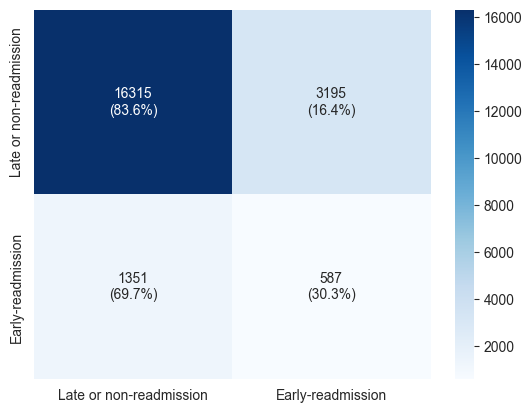

In [56]:
# Visualize confusion matrix with both absolute and percentage values
cm_smote = confusion_matrix(y_test, y_test_pred_smote)
cm_smote_norm = confusion_matrix(y_test, y_test_pred_smote, normalize='true')

annotations_smote = np.array([
    [f"{val}\n({perc:.1%})" for val, perc in zip(row, norm_row)]
    for row, norm_row in zip(cm_smote, cm_smote_norm)
])

sns.heatmap(
    cm_smote,
    annot=annotations_smote,
    cmap='Blues',
    fmt='',
    xticklabels=['Late or non-readmission', 'Early-readmission'],
    yticklabels=['Late or non-readmission', 'Early-readmission']
)

## **5. Optuna Hyper-parameter Tuning | SMOTE + Tomek Links**
Hyper-parameter tuning of the model using Optuna, by oversampling with SMOTE and undersampling with Tomek Links.

### 5.1 Objective & study setup
Preparing the objective function with all hyper-parameters, and creating/loading the Optuna study.

In [57]:
def objective(trial: optuna.Trial) -> float:
    # Hyperparameter search space
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 200),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 1.0, log=True),
        "algorithm": trial.suggest_categorical("algorithm", ["SAMME", "SAMME.R"])
    }
    
    # Build pipeline
    pipeline = make_pipeline(
        SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'), random_state=RANDOM_STATE),
        AdaBoostClassifier(**params, random_state=RANDOM_STATE)
    )
    
    # Define validation folds
    kf = StratifiedKFold(n_splits=5, shuffle=False)
    
    # Cross validation
    scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring=SCORING)

    print("Cross validation scores: {}".format(scores))
    print("Average score: {}".format(scores.mean()))

    return scores.mean()

In [58]:
# Set up study with name and storage
storage = JournalStorage(JournalFileBackend(STUDY_PATH_SMOTE_TOMEK))

study = optuna.create_study(
    direction="maximize",
    study_name=STUDY_NAME,
    storage=storage,
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(constant_liar=True, seed=RANDOM_STATE),
    pruner=optuna.pruners.SuccessiveHalvingPruner()
)

optuna.logging.set_verbosity(optuna.logging.INFO)

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\_experimental.py:31: ExperimentalWarning:

Argument ``constant_liar`` is an experimental feature. The interface can change in the future.

[I 2025-01-12 18:00:26,637] A new study created in Journal with name: Diabetes_130-US


### 5.2 Hyper-parameter tuning
**(CAUTION)** <u>Do not run</u>, unless you already need to find the best parameters. If you already have bound the best model configuration, <u>run the section above</u> _(Objective & study setup)_.

In [59]:
study.optimize(
    objective,
    n_trials=N_TRIALS,
    n_jobs=-1 # Use all available cores
)

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.21906585 0.21784363 0.22125303 0.21919042 0.21802969]
Average score: 0.21907652201463526


[I 2025-01-12 18:01:18,409] Trial 2 finished with value: 0.21907652201463526 and parameters: {'n_estimators': 26, 'learning_rate': 0.011029259975271342, 'algorithm': 'SAMME.R'}. Best is trial 2 with value: 0.21907652201463526.
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.



Cross validation scores: [0.41057389 0.40164625 0.38324055 0.44091189 0.40538556]
Average score: 0.4083516268797517


[I 2025-01-12 18:01:32,867] Trial 4 finished with value: 0.4083516268797517 and parameters: {'n_estimators': 73, 'learning_rate': 0.0160894341480794, 'algorithm': 'SAMME.R'}. Best is trial 4 with value: 0.4083516268797517.
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 1

Cross validation scores: [0.46193098 0.46645669 0.4689293  0.45820655 0.45854479]
Average score: 0.4628136613321202


[I 2025-01-12 18:01:48,803] Trial 0 finished with value: 0.4280468317767097 and parameters: {'n_estimators': 169, 'learning_rate': 0.06658400574613973, 'algorithm': 'SAMME'}. Best is trial 1 with value: 0.4628136613321202.


Cross validation scores: [0.43140754 0.42926756 0.44083587 0.41703435 0.42168883]
Average score: 0.4280468317767097


[I 2025-01-12 18:01:49,924] Trial 3 finished with value: 0.4244728037090657 and parameters: {'n_estimators': 156, 'learning_rate': 0.048448319091892594, 'algorithm': 'SAMME'}. Best is trial 1 with value: 0.4628136613321202.


Cross validation scores: [0.4238766  0.42750169 0.43797308 0.4134243  0.41958834]
Average score: 0.4244728037090657


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 18:02:00,719] Trial 5 finished with value: 0.501618784279618 and parameters: {'n_estimators': 174, 'learning_rate': 0.22401820417382295, 'algorithm': 'SAMME.R'}. Best is trial 5 with value: 0.501618784279618.


Cross validation scores: [0.49891918 0.50291855 0.5059048  0.49798496 0.50236642]
Average score: 0.501618784279618


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 18:02:22,746] Trial 6 finished with value: 0.47514547484458414 and parameters: {'n_estimators': 72, 'learning_rate': 0.18117221728642244, 'algorithm': 'SAMME.R'}. Best is trial 5 with value: 0.501618784279618.


Cross validation scores: [0.47150365 0.47653611 0.48239413 0.46954001 0.47575348]
Average score: 0.47514547484458414


[I 2025-01-12 18:02:28,282] Trial 7 finished with value: 0.4329500003354211 and parameters: {'n_estimators': 54, 'learning_rate': 0.19775514201791858, 'algorithm': 'SAMME'}. Best is trial 5 with value: 0.501618784279618.


Cross validation scores: [0.44916842 0.41425715 0.44231358 0.41793529 0.44107556]
Average score: 0.4329500003354211


[I 2025-01-12 18:02:29,531] Trial 8 finished with value: 0.3722145075746677 and parameters: {'n_estimators': 13, 'learning_rate': 0.26162731214417834, 'algorithm': 'SAMME'}. Best is trial 5 with value: 0.501618784279618.


Cross validation scores: [0.41097029 0.36718423 0.35218524 0.29613394 0.43459883]
Average score: 0.3722145075746677


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.4686507  0.46456138 0.46328183 0.44983599 0.45603829]
Average score: 0.4604736385850409


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 18:02:57,947] Trial 11 finished with value: 0.4604736385850409 and parameters: {'n_estimators': 55, 'learning_rate': 0.5540249478080522, 'algorithm': 'SAMME'}. Best is trial 5 with value: 0.501618784279618.
[I 2025-01-12 18:03:05,740] Trial 9 finished with value: 0.5141507746399372 and parameters: {'n_estimators': 150, 'learning_rate': 0.6845164965465149, 'algorithm': 'SAMME'}. Best is trial 9 with value: 0.5141507746399372.


Cross validation scores: [0.51698205 0.51185986 0.52308897 0.50986309 0.5089599 ]
Average score: 0.5141507746399372


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 18:03:15,590] Trial 10 finished with value: 0.5296965683697848 and parameters: {'n_estimators': 151, 'learning_rate': 0.5234943492856025, 'algorithm': 'SAMME.R'}. Best is trial 10 with value: 0.5296965683697848.


Cross validation scores: [0.52322271 0.52595003 0.53611046 0.53021931 0.53298033]
Average score: 0.5296965683697848


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 18:03:18,369] Trial 12 finished with value: 0.4641735621187471 and parameters: {'n_estimators': 53, 'learning_rate': 0.49042240855351227, 'algorithm': 'SAMME'}. Best is trial 10 with value: 0.5296965683697848.


Cross validation scores: [0.46776688 0.44586615 0.47620051 0.46361487 0.4674194 ]
Average score: 0.4641735621187471


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.41057389 0.40772182 0.43712778 0.4117917  0.41786934]
Average score: 0.41701690645647227


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.



Cross validation scores: [0.53289077 0.52576346 0.53667439 0.52614268 0.52746866]
Average score: 0.5297879919653019


[I 2025-01-12 18:04:02,364] Trial 14 finished with value: 0.5297879919653019 and parameters: {'n_estimators': 179, 'learning_rate': 0.44460749876033756, 'algorithm': 'SAMME.R'}. Best is trial 14 with value: 0.5297879919653019.
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.



Cross validation scores: [0.53036561 0.52880941 0.55064745 0.53149571 0.50745297]
Average score: 0.5297542290213763


[I 2025-01-12 18:04:20,838] Trial 16 finished with value: 0.5297542290213763 and parameters: {'n_estimators': 129, 'learning_rate': 0.8945775362426973, 'algorithm': 'SAMME'}. Best is trial 14 with value: 0.5297879919653019.
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 18:04:29,046] Trial 17 finished with value: 0.5319619232539669 and parameters: {'n_estimators': 139, 'learning_rate': 0.8972177871395254, 'algorithm': 'SAMME'}. Best is trial 17 with value: 0.5319619232539669.


Cross validation scores: [0.52678433 0.53297595 0.55364184 0.52309659 0.5233109 ]
Average score: 0.5319619232539669


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 18:04:34,305] Trial 15 finished with value: 0.459037618325106 and parameters: {'n_estimators': 199, 'learning_rate': 0.0352512131584828, 'algorithm': 'SAMME.R'}. Best is trial 17 with value: 0.5319619232539669.


Cross validation scores: [0.45948389 0.46468174 0.45841798 0.45714603 0.45545846]
Average score: 0.459037618325106
Cross validation scores: [0.44397883 0.43365586 0.43313645 0.41939202 0.42779491]
Average score: 0.4315916131240911


[I 2025-01-12 18:04:34,506] Trial 18 finished with value: 0.4315916131240911 and parameters: {'n_estimators': 143, 'learning_rate': 0.11915599737690646, 'algorithm': 'SAMME'}. Best is trial 17 with value: 0.5319619232539669.
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Wor

Cross validation scores: [0.51776274 0.51971436 0.52827968 0.51560981 0.5185738 ]
Average score: 0.5199880779660944


[I 2025-01-12 18:05:17,320] Trial 19 finished with value: 0.5199880779660944 and parameters: {'n_estimators': 199, 'learning_rate': 0.31248309769434823, 'algorithm': 'SAMME.R'}. Best is trial 17 with value: 0.5319619232539669.
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_W

Cross validation scores: [0.5339166  0.53996506 0.53289012 0.53452438 0.51773831]
Average score: 0.5318068928723549


[I 2025-01-12 18:05:34,540] Trial 21 finished with value: 0.5318068928723549 and parameters: {'n_estimators': 129, 'learning_rate': 0.9111558303725328, 'algorithm': 'SAMME'}. Best is trial 17 with value: 0.5319619232539669.
[I 2025-01-12 18:05:35,862] Trial 20 finished with value: 0.5251628862593083 and parameters: {'n_estimators': 178, 'learning_rate': 0.3994863700646279, 'algorithm': 'SAMME.R'}. Best is trial 17 with value: 0.5319619232539669.


Cross validation scores: [0.52581095 0.52191135 0.53821588 0.51786099 0.52201526]
Average score: 0.5251628862593083


[I 2025-01-12 18:05:38,145] Trial 22 finished with value: 0.4770300578739651 and parameters: {'n_estimators': 92, 'learning_rate': 0.1549438352263387, 'algorithm': 'SAMME.R'}. Best is trial 17 with value: 0.5319619232539669.


Cross validation scores: [0.4715773  0.47613756 0.48430942 0.4769468  0.47617921]
Average score: 0.4770300578739651


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 18:05:47,078] Trial 23 finished with value: 0.4582335491417221 and parameters: {'n_estimators': 127, 'learning_rate': 0.30499167734836535, 'algorithm': 'SAMME'}. Best is trial 17 with value: 0.5319619232539669.


Cross validation scores: [0.46421903 0.46901787 0.45217313 0.45546129 0.45029644]
Average score: 0.4582335491417221


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 18:06:07,885] Trial 24 finished with value: 0.5406952947485484 and parameters: {'n_estimators': 185, 'learning_rate': 0.9521782270514509, 'algorithm': 'SAMME.R'}. Best is trial 24 with value: 0.5406952947485484.


Cross validation scores: [0.53584197 0.54466794 0.53924401 0.54116731 0.54255525]
Average score: 0.5406952947485484
Cross validation scores: [0.47940158 0.49213612 0.47326963 0.46857585 0.476771  ]
Average score: 0.4780308360818951


[I 2025-01-12 18:06:36,687] Trial 25 finished with value: 0.4780308360818951 and parameters: {'n_estimators': 161, 'learning_rate': 0.3665977917682494, 'algorithm': 'SAMME'}. Best is trial 24 with value: 0.5406952947485484.
[I 2025-01-12 18:06:38,979] Trial 27 finished with value: 0.49705167325850574 and parameters: {'n_estimators': 89, 'learning_rate': 0.708272419688761, 'algorithm': 'SAMME'}. Best is trial 24 with value: 0.5406952947485484.


Cross validation scores: [0.50449905 0.49929253 0.50900949 0.48477957 0.48767773]
Average score: 0.49705167325850574


[I 2025-01-12 18:06:46,695] Trial 26 finished with value: 0.51582457652646 and parameters: {'n_estimators': 130, 'learning_rate': 0.718414513170362, 'algorithm': 'SAMME'}. Best is trial 24 with value: 0.5406952947485484.


Cross validation scores: [0.52492604 0.51765105 0.53413039 0.49936194 0.50305346]
Average score: 0.51582457652646


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 18:06:54,827] Trial 28 finished with value: 0.5390729788969368 and parameters: {'n_estimators': 138, 'learning_rate': 0.9619461419203367, 'algorithm': 'SAMME'}. Best is trial 24 with value: 0.5406952947485484.


Cross validation scores: [0.53418576 0.54758708 0.55515728 0.53122746 0.52720732]
Average score: 0.5390729788969368


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 18:07:07,045] Trial 29 finished with value: 0.4918617600902365 and parameters: {'n_estimators': 171, 'learning_rate': 0.44660419759932063, 'algorithm': 'SAMME'}. Best is trial 24 with value: 0.5406952947485484.


Cross validation scores: [0.4896536  0.49145036 0.49801107 0.48087865 0.49931511]
Average score: 0.4918617600902365


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 18:07:34,570] Trial 30 finished with value: 0.5386915568039545 and parameters: {'n_estimators': 188, 'learning_rate': 0.8272597490144664, 'algorithm': 'SAMME'}. Best is trial 24 with value: 0.5406952947485484.


Cross validation scores: [0.53942738 0.54156911 0.54816811 0.53599367 0.52829951]
Average score: 0.5386915568039545


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 18:07:47,527] Trial 31 finished with value: 0.5352065394851888 and parameters: {'n_estimators': 120, 'learning_rate': 0.9719401344613181, 'algorithm': 'SAMME'}. Best is trial 24 with value: 0.5406952947485484.


Cross validation scores: [0.54062161 0.5287436  0.5517552  0.52928394 0.52562835]
Average score: 0.5352065394851888


[I 2025-01-12 18:07:50,176] Trial 32 finished with value: 0.4618885556100256 and parameters: {'n_estimators': 99, 'learning_rate': 0.07801817955097458, 'algorithm': 'SAMME.R'}. Best is trial 24 with value: 0.5406952947485484.


Cross validation scores: [0.46298583 0.46520159 0.46772442 0.46297685 0.45055409]
Average score: 0.4618885556100256


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 18:07:55,902] Trial 33 finished with value: 0.48919821107353484 and parameters: {'n_estimators': 116, 'learning_rate': 0.5779837752810424, 'algorithm': 'SAMME'}. Best is trial 24 with value: 0.5406952947485484.


Cross validation scores: [0.49390852 0.49178221 0.50527759 0.46856953 0.48645321]
Average score: 0.48919821107353484


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 18:08:17,393] Trial 34 finished with value: 0.4468095652755496 and parameters: {'n_estimators': 145, 'learning_rate': 0.028351893282054143, 'algorithm': 'SAMME.R'}. Best is trial 24 with value: 0.5406952947485484.


Cross validation scores: [0.45578562 0.44946467 0.44534619 0.43601411 0.44743724]
Average score: 0.4468095652755496


[I 2025-01-12 18:08:23,119] Trial 35 finished with value: 0.43546539676464696 and parameters: {'n_estimators': 138, 'learning_rate': 0.13363454057976804, 'algorithm': 'SAMME'}. Best is trial 24 with value: 0.5406952947485484.


Cross validation scores: [0.42211744 0.44656465 0.44247333 0.42041518 0.44575638]
Average score: 0.43546539676464696


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 18:09:01,978] Trial 36 finished with value: 0.5285383223258406 and parameters: {'n_estimators': 188, 'learning_rate': 0.7513531202170282, 'algorithm': 'SAMME'}. Best is trial 24 with value: 0.5406952947485484.


Cross validation scores: [0.53078448 0.52575841 0.53850351 0.52470565 0.52293956]
Average score: 0.5285383223258406


[I 2025-01-12 18:09:06,141] Trial 39 finished with value: 0.5411666742843837 and parameters: {'n_estimators': 117, 'learning_rate': 0.9999522278664293, 'algorithm': 'SAMME'}. Best is trial 39 with value: 0.5411666742843837.


Cross validation scores: [0.52365414 0.54734766 0.5593366  0.54578274 0.52971223]
Average score: 0.5411666742843837


[I 2025-01-12 18:09:06,910] Trial 37 finished with value: 0.5379450827720366 and parameters: {'n_estimators': 162, 'learning_rate': 0.9738210172067762, 'algorithm': 'SAMME'}. Best is trial 39 with value: 0.5411666742843837.


Cross validation scores: [0.53811889 0.54241256 0.54832951 0.53324902 0.52761544]
Average score: 0.5379450827720366


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 18:09:15,635] Trial 38 finished with value: 0.5188058188159748 and parameters: {'n_estimators': 187, 'learning_rate': 0.6480585082917211, 'algorithm': 'SAMME'}. Best is trial 39 with value: 0.5411666742843837.


Cross validation scores: [0.51949868 0.51948218 0.5284868  0.50703329 0.51952815]
Average score: 0.5188058188159748


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.



Cross validation scores: [0.46101113 0.45796308 0.47492302 0.46196922 0.46666637]
Average score: 0.46450656531809303


[I 2025-01-12 18:09:37,033] Trial 40 finished with value: 0.46450656531809303 and parameters: {'n_estimators': 164, 'learning_rate': 0.25802957758037937, 'algorithm': 'SAMME'}. Best is trial 39 with value: 0.5411666742843837.
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.



Cross validation scores: [0.53670188 0.54345334 0.545164   0.54429166 0.52819562]
Average score: 0.5395612994126415


[I 2025-01-12 18:09:56,933] Trial 41 finished with value: 0.5395612994126415 and parameters: {'n_estimators': 188, 'learning_rate': 0.7885712965681537, 'algorithm': 'SAMME.R'}. Best is trial 39 with value: 0.5411666742843837.
[I 2025-01-12 18:10:04,040] Trial 42 finished with value: 0.4776725820217626 and parameters: {'n_estimators': 86, 'learning_rate': 0.5759460645596072, 'algorithm': 'SAMME'}. Best is trial 39 with value: 0.5411666742843837.


Cross validation scores: [0.47631876 0.48459504 0.48612185 0.46582414 0.47550312]
Average score: 0.4776725820217626


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 18:10:11,833] Trial 43 finished with value: 0.3968807264553659 and parameters: {'n_estimators': 101, 'learning_rate': 0.05861921063269801, 'algorithm': 'SAMME'}. Best is trial 39 with value: 0.5411666742843837.


Cross validation scores: [0.42306538 0.38122226 0.39327277 0.36874736 0.41809587]
Average score: 0.3968807264553659


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 18:10:17,733] Trial 45 finished with value: 0.4835982283129514 and parameters: {'n_estimators': 78, 'learning_rate': 0.6019199284167273, 'algorithm': 'SAMME'}. Best is trial 39 with value: 0.5411666742843837.


Cross validation scores: [0.48237794 0.48370135 0.49969085 0.47149048 0.48073053]
Average score: 0.4835982283129514


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.52208245 0.51526239 0.53023056 0.51054199 0.51783907]
Average score: 0.5191912928367552


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.53583473 0.53568861 0.54659892 0.54122231 0.52385385]
Average score: 0.5366396831065974


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.53495712 0.54656575 0.54539087 0.54495995 0.5334983 ]
Average score: 0.5410743992658286


[I 2025-01-12 18:11:30,729] Trial 47 finished with value: 0.5410743992658286 and parameters: {'n_estimators': 187, 'learning_rate': 0.7466584902967204, 'algorithm': 'SAMME.R'}. Best is trial 39 with value: 0.5411666742843837.
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Wo

Cross validation scores: [0.5368139  0.54726916 0.54685299 0.54360933 0.53538766]
Average score: 0.5419866094539635


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 18:11:45,490] Trial 49 finished with value: 0.530656739993691 and parameters: {'n_estimators': 183, 'learning_rate': 0.4715600052057279, 'algorithm': 'SAMME.R'}. Best is trial 48 with value: 0.5419866094539635.


Cross validation scores: [0.52914514 0.52968358 0.54300795 0.5266821  0.52476492]
Average score: 0.530656739993691


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 18:11:54,221] Trial 50 finished with value: 0.5393242895080298 and parameters: {'n_estimators': 192, 'learning_rate': 0.7879257337492851, 'algorithm': 'SAMME.R'}. Best is trial 48 with value: 0.5419866094539635.


Cross validation scores: [0.53510841 0.54207333 0.54641592 0.54469331 0.52833048]
Average score: 0.5393242895080298


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.52581641 0.54016158 0.53672115 0.53357624 0.52367982]
Average score: 0.531991040462834


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.50402448 0.50557915 0.50675006 0.49842896 0.5064422 ]
Average score: 0.5042449688135227


[I 2025-01-12 18:12:34,837] Trial 52 finished with value: 0.5042449688135227 and parameters: {'n_estimators': 177, 'learning_rate': 0.22778070714406357, 'algorithm': 'SAMME.R'}. Best is trial 48 with value: 0.5419866094539635.
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 18:12:37,413] Trial 54 finished with value: 0.4816911239997091 and parameters: {'n_estimators': 36, 'learning_rate': 0.3914279848494074, 'algorithm': 'SAMME.R'}. Best is trial 48 with value: 0.5419866094539635.


Cross validation scores: [0.4861711  0.48114608 0.49232236 0.47927043 0.46954565]
Average score: 0.4816911239997091


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.52575899 0.53317147 0.52871523 0.52852277 0.52425375]
Average score: 0.528084439917775


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.53868399 0.53460499 0.5386184  0.532984   0.52654155]
Average score: 0.5342865873418972


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 18:13:26,005] Trial 55 finished with value: 0.5342865873418972 and parameters: {'n_estimators': 194, 'learning_rate': 0.5009439817997368, 'algorithm': 'SAMME.R'}. Best is trial 48 with value: 0.5419866094539635.
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 18:13:32,387] Trial 56 finished with value: 0.5370537094757756 and parameters: {'n_estimators': 194, 'learning_rate': 0.7984954838125612, 'algorithm': 'SAMME.R'}. Best is trial 48 with value: 0.5419866094539635.


Cross validation scores: [0.53293613 0.54142392 0.54071491 0.53997691 0.53021669]
Average score: 0.5370537094757756


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.53708743 0.54008302 0.54504545 0.54127645 0.53096251]
Average score: 0.5388909738305857


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.53772149 0.54209472 0.5415852  0.54456844 0.53859555]
Average score: 0.5409130806012683


[I 2025-01-12 18:14:12,837] Trial 58 finished with value: 0.5409130806012683 and parameters: {'n_estimators': 193, 'learning_rate': 0.7929885964276124, 'algorithm': 'SAMME.R'}. Best is trial 48 with value: 0.5419866094539635.
[I 2025-01-12 18:14:13,037] Trial 59 finished with value: 0.5382735738481474 and parameters: {'n_estimators': 181, 'learning_rate': 0.6051368926877205, 'algorithm': 'SAMME.R'}. Best is trial 48 with value: 0.5419866094539635.


Cross validation scores: [0.5370306  0.53651643 0.54831178 0.53504336 0.53446569]
Average score: 0.5382735738481474


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 18:14:16,138] Trial 60 finished with value: 0.5403863012552467 and parameters: {'n_estimators': 167, 'learning_rate': 0.7044385432398005, 'algorithm': 'SAMME.R'}. Best is trial 48 with value: 0.5419866094539635.


Cross validation scores: [0.53205039 0.54752077 0.54865464 0.54092147 0.53278423]
Average score: 0.5403863012552467


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.5281828  0.52312057 0.53912136 0.51800866 0.5261791 ]
Average score: 0.5269224995931749


[I 2025-01-12 18:14:58,485] Trial 61 finished with value: 0.5269224995931749 and parameters: {'n_estimators': 174, 'learning_rate': 0.42172349300402556, 'algorithm': 'SAMME.R'}. Best is trial 48 with value: 0.5419866094539635.
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-

Cross validation scores: [0.45547107 0.44915472 0.44775866 0.43276269 0.44774749]
Average score: 0.4465789246556091


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 18:15:14,179] Trial 64 finished with value: 0.5190509556222335 and parameters: {'n_estimators': 65, 'learning_rate': 0.8080586872831235, 'algorithm': 'SAMME.R'}. Best is trial 48 with value: 0.5419866094539635.


Cross validation scores: [0.5211063  0.51215828 0.52513213 0.52188936 0.51496871]
Average score: 0.5190509556222335


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 18:15:23,429] Trial 63 finished with value: 0.5339466074590693 and parameters: {'n_estimators': 194, 'learning_rate': 0.4965694882974086, 'algorithm': 'SAMME.R'}. Best is trial 48 with value: 0.5419866094539635.


Cross validation scores: [0.53513458 0.52961482 0.54722829 0.53230099 0.52545436]
Average score: 0.5339466074590693


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.47694358 0.48036081 0.48724698 0.47784879 0.48128591]
Average score: 0.4807372130830805


[I 2025-01-12 18:15:45,849] Trial 65 finished with value: 0.4807372130830805 and parameters: {'n_estimators': 181, 'learning_rate': 0.1004560015139874, 'algorithm': 'SAMME.R'}. Best is trial 48 with value: 0.5419866094539635.
[I 2025-01-12 18:15:47,858] Trial 66 finished with value: 0.5377709735378543 and parameters: {'n_estimators': 169, 'learning_rate': 0.6784617063736378, 'algorithm': 'SAMME.R'}. Best is trial 48 with value: 0.5419866094539635.


Cross validation scores: [0.53430009 0.53665477 0.54176131 0.54186806 0.53427063]
Average score: 0.5377709735378543


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.53339014 0.54183431 0.54917254 0.53637615 0.5396865 ]
Average score: 0.5400919292248314


[I 2025-01-12 18:16:29,633] Trial 67 finished with value: 0.5400919292248314 and parameters: {'n_estimators': 168, 'learning_rate': 0.8552901046713651, 'algorithm': 'SAMME.R'}. Best is trial 48 with value: 0.5419866094539635.
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Wo

Cross validation scores: [0.53305607 0.54648371 0.54689697 0.53818796 0.5307338 ]
Average score: 0.5390717020153553


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 18:16:51,334] Trial 69 finished with value: 0.5422967001559049 and parameters: {'n_estimators': 184, 'learning_rate': 0.7045579881258246, 'algorithm': 'SAMME.R'}. Best is trial 69 with value: 0.5422967001559049.


Cross validation scores: [0.53681203 0.54444876 0.54904569 0.54492597 0.53625106]
Average score: 0.5422967001559049


[I 2025-01-12 18:16:52,451] Trial 70 finished with value: 0.530301340282161 and parameters: {'n_estimators': 157, 'learning_rate': 0.5274131712886034, 'algorithm': 'SAMME.R'}. Best is trial 69 with value: 0.5422967001559049.


Cross validation scores: [0.52465117 0.52521753 0.54497445 0.53102442 0.52563913]
Average score: 0.530301340282161


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.51792255 0.51670022 0.52644195 0.51396099 0.51815992]
Average score: 0.5186371258166107


[I 2025-01-12 18:17:17,964] Trial 71 finished with value: 0.5186371258166107 and parameters: {'n_estimators': 176, 'learning_rate': 0.35109326191815204, 'algorithm': 'SAMME.R'}. Best is trial 69 with value: 0.5422967001559049.
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-

Cross validation scores: [0.53758589 0.54547185 0.55028329 0.54064155 0.52986903]
Average score: 0.5407703231720173


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.



Cross validation scores: [0.45053285 0.44635259 0.45933854 0.44812493 0.51919273]
Average score: 0.4647083265930572


[I 2025-01-12 18:17:31,171] Trial 74 finished with value: 0.4647083265930572 and parameters: {'n_estimators': 10, 'learning_rate': 0.9153444550304612, 'algorithm': 'SAMME.R'}. Best is trial 69 with value: 0.5422967001559049.
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Wor

Cross validation scores: [0.53443531 0.54016011 0.54580146 0.53808108 0.5392039 ]
Average score: 0.5395363707896599


[I 2025-01-12 18:18:01,659] Trial 73 finished with value: 0.5395363707896599 and parameters: {'n_estimators': 167, 'learning_rate': 0.8311948480584035, 'algorithm': 'SAMME.R'}. Best is trial 69 with value: 0.5422967001559049.
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Wo

Cross validation scores: [0.43283105 0.42091986 0.43816434 0.41584779 0.41892976]
Average score: 0.4253385593696552
Cross validation scores: [0.51414985 0.5125346  0.52288118 0.51068033 0.51205291]
Average score: 0.514459772978916


[I 2025-01-12 18:18:27,102] Trial 75 finished with value: 0.514459772978916 and parameters: {'n_estimators': 183, 'learning_rate': 0.2911664833974625, 'algorithm': 'SAMME.R'}. Best is trial 69 with value: 0.5422967001559049.
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Wor

Cross validation scores: [0.53972472 0.53271333 0.53743042 0.53856938 0.53381429]
Average score: 0.5364504289108913


[I 2025-01-12 18:18:43,250] Trial 77 finished with value: 0.5364504289108913 and parameters: {'n_estimators': 146, 'learning_rate': 0.7282290020974429, 'algorithm': 'SAMME.R'}. Best is trial 69 with value: 0.5422967001559049.
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Wo

Cross validation scores: [0.53472189 0.54638804 0.54759501 0.54060618 0.53147018]
Average score: 0.5401562609893465


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 18:19:08,407] Trial 79 finished with value: 0.5367284040131983 and parameters: {'n_estimators': 190, 'learning_rate': 0.5857646440116872, 'algorithm': 'SAMME.R'}. Best is trial 69 with value: 0.5422967001559049.


Cross validation scores: [0.53607722 0.53730887 0.54727485 0.53566404 0.52731704]
Average score: 0.5367284040131983


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.52775425 0.52490774 0.53861693 0.52170895 0.52284435]
Average score: 0.5271664428850349


[I 2025-01-12 18:19:34,389] Trial 80 finished with value: 0.5271664428850349 and parameters: {'n_estimators': 182, 'learning_rate': 0.43731723394967364, 'algorithm': 'SAMME.R'}. Best is trial 69 with value: 0.5422967001559049.
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_W

Cross validation scores: [0.53212481 0.53445253 0.54311168 0.535949   0.52992679]
Average score: 0.5351129622446255


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.53198097 0.5392428  0.53928244 0.54086939 0.52991201]
Average score: 0.5362575198385515


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.5340546  0.54424668 0.55125008 0.54133508 0.53306874]
Average score: 0.5407910369113332


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.53395662 0.53779799 0.54938107 0.54003526 0.53032862]
Average score: 0.5382999119838706


[I 2025-01-12 18:20:37,098] Trial 85 finished with value: 0.5336095256337622 and parameters: {'n_estimators': 159, 'learning_rate': 0.532413677432432, 'algorithm': 'SAMME.R'}. Best is trial 69 with value: 0.5422967001559049.


Cross validation scores: [0.52805369 0.53480882 0.54717333 0.53128336 0.52672844]
Average score: 0.5336095256337622


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.53941957 0.54230975 0.548696   0.54405698 0.52996646]
Average score: 0.5408897527378538


[I 2025-01-12 18:21:10,346] Trial 86 finished with value: 0.5408897527378538 and parameters: {'n_estimators': 196, 'learning_rate': 0.7098005491698408, 'algorithm': 'SAMME.R'}. Best is trial 69 with value: 0.5422967001559049.
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Wo

Cross validation scores: [0.53718549 0.54433924 0.54664955 0.54576281 0.53505776]
Average score: 0.5417989710899619


[I 2025-01-12 18:21:26,579] Trial 87 finished with value: 0.5417989710899619 and parameters: {'n_estimators': 191, 'learning_rate': 0.7204636594069525, 'algorithm': 'SAMME.R'}. Best is trial 69 with value: 0.5422967001559049.
d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Wo

Cross validation scores: [0.53355634 0.53651643 0.5420066  0.53620798 0.53027256]
Average score: 0.5357119843802198


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 18:21:52,004] Trial 89 finished with value: 0.5396013201278589 and parameters: {'n_estimators': 173, 'learning_rate': 0.8656181476000973, 'algorithm': 'SAMME.R'}. Best is trial 69 with value: 0.5422967001559049.


Cross validation scores: [0.53432118 0.54478701 0.54499825 0.53745084 0.53644933]
Average score: 0.5396013201278589


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.53109245 0.5295844  0.54108384 0.52669121 0.52751512]
Average score: 0.5311934040669538


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 18:22:15,124] Trial 91 finished with value: 0.46292487132119114 and parameters: {'n_estimators': 191, 'learning_rate': 0.04588852168811791, 'algorithm': 'SAMME.R'}. Best is trial 69 with value: 0.5422967001559049.


Cross validation scores: [0.46158312 0.46666609 0.46977156 0.46392655 0.45267704]
Average score: 0.46292487132119114


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.49333179 0.47313035 0.4758737  0.47178257 0.48865811]
Average score: 0.4805553066747807


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.5255199  0.52307663 0.53478796 0.52432526 0.52121103]
Average score: 0.5257841568277719


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.53669832 0.54907083 0.54801982 0.5433489  0.53508735]
Average score: 0.5424450435739665


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Cross validation scores: [0.53478473 0.53531781 0.55291294 0.53623957 0.52890465]
Average score: 0.537631940171444


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 18:23:34,833] Trial 96 finished with value: 0.5408646785837453 and parameters: {'n_estimators': 191, 'learning_rate': 0.7325573256181596, 'algorithm': 'SAMME.R'}. Best is trial 93 with value: 0.5424450435739665.


Cross validation scores: [0.53375892 0.54535007 0.54333554 0.54574151 0.53613735]
Average score: 0.5408646785837453


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 18:23:43,542] Trial 97 finished with value: 0.5386850398787035 and parameters: {'n_estimators': 186, 'learning_rate': 0.8762847361426793, 'algorithm': 'SAMME.R'}. Best is trial 93 with value: 0.5424450435739665.


Cross validation scores: [0.53231228 0.54284384 0.54828601 0.53894435 0.53103872]
Average score: 0.5386850398787035


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 18:23:54,183] Trial 98 finished with value: 0.5394452450606041 and parameters: {'n_estimators': 195, 'learning_rate': 0.7730426086494879, 'algorithm': 'SAMME.R'}. Best is trial 93 with value: 0.5424450435739665.


Cross validation scores: [0.53867978 0.54192256 0.54580556 0.53951036 0.53130796]
Average score: 0.5394452450606041


d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-01-12 18:24:00,607] Trial 99 finished with value: 0.5408412046461704 and parameters: {'n_estimators': 178, 'learning_rate': 0.66919340688524, 'algorithm': 'SAMME.R'}. Best is trial 93 with value: 0.5424450435739665.


Cross validation scores: [0.53715492 0.54737397 0.5456216  0.5387873  0.53526824]
Average score: 0.5408412046461704


In [60]:
print('Best Trial: {}'.format(study.best_trial.number))
print('Best Parameters: {}'.format(study.best_params))
print('Best Value: {}'.format(study.best_value))

Best Trial: 93
Best Parameters: {'n_estimators': 200, 'learning_rate': 0.7287940582916982, 'algorithm': 'SAMME.R'}
Best Value: 0.5424450435739665


### 5.3 Optuna Visualizations
Visualizing hyper-parameter tuning results obtained by running Optuna.

In [61]:
optuna.visualization.plot_optimization_history(study)

In [62]:
optuna.visualization.plot_slice(study)

In [63]:
optuna.visualization.plot_param_importances(study)

In [64]:
optuna.visualization.plot_parallel_coordinate(study)

In [65]:
optuna.visualization.plot_contour(study)

In [66]:
optuna.visualization.plot_timeline(study)

### 5.4 Fitting Best Model
Fitting the final model using the best hyper-parameters found by Optuna.

In [67]:
# Fit best model on the training set
best_params = study.best_params

# Ensure the solver is compatible with the penalty
if best_params.get("penalty") == "elasticnet":
    best_params["solver"] = "saga"
    
pipeline_smotetomek = make_pipeline(
    SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'), random_state=RANDOM_STATE),
    AdaBoostClassifier(**best_params, random_state=RANDOM_STATE)
)

pipeline_smotetomek.fit(X_train, y_train)

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.



Pipeline(steps=[('smotetomek',
                 SMOTETomek(random_state=38,
                            tomek=TomekLinks(sampling_strategy='majority'))),
                ('adaboostclassifier',
                 AdaBoostClassifier(learning_rate=0.7287940582916982,
                                    n_estimators=200, random_state=38))])

In [68]:
# Predictions
y_train_pred_smotetomek = pipeline_smotetomek.predict(X_train)
y_test_pred_smotetomek = pipeline_smotetomek.predict(X_test)

In [69]:
ac_train_smotetomek = accuracy_score(y_train, y_train_pred_smotetomek)
ac_test_smotetomek = accuracy_score(y_test, y_test_pred_smotetomek)

print('Train accuracy: ', ac_train_smotetomek)
print('Test accuracy: ', ac_test_smotetomek)

Train accuracy:  0.7904685782795484
Test accuracy:  0.79177545691906


In [70]:
# Visualize precision, recall, F1-score
print(classification_report(
    y_test, y_test_pred_smotetomek,
    target_names=['Late or non-readmission', 'Early-readmission']
))

                         precision    recall  f1-score   support

Late or non-readmission       0.92      0.84      0.88     19510
      Early-readmission       0.15      0.29      0.20      1938

               accuracy                           0.79     21448
              macro avg       0.54      0.57      0.54     21448
           weighted avg       0.85      0.79      0.82     21448



In [71]:
# Compute precision, recall, F1-score, ROC-AUC-score, and accuracy
recall_smotetomek = recall_score(y_test, y_test_pred_smotetomek, average='macro')
precision_smotetomek = precision_score(y_test, y_test_pred_smotetomek, average='macro')
f1_smotetomek = f1_score(y_test, y_test_pred_smotetomek, average='macro')
roc_auc_smotetomek = roc_auc_score(y_test, y_test_pred_smotetomek, average='macro')
accuracy_smotetomek = accuracy_score(y_test, y_test_pred_smotetomek)

<Axes: >

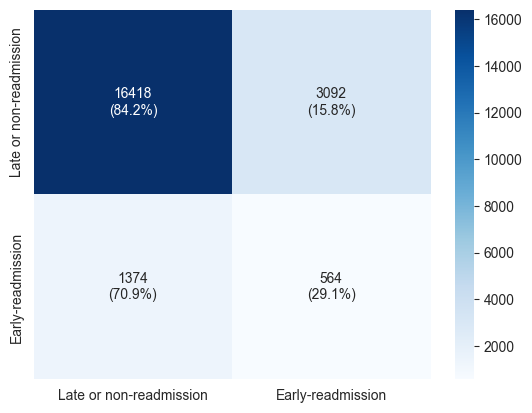

In [72]:
# Visualize confusion matrix with both absolute and percentage values
cm_smotetomek = confusion_matrix(y_test, y_test_pred_smotetomek)
cm_smotetomek_norm = confusion_matrix(y_test, y_test_pred_smotetomek, normalize='true')

annotations_smotetomek = np.array([
    [f"{val}\n({perc:.1%})" for val, perc in zip(row, norm_row)]
    for row, norm_row in zip(cm_smotetomek, cm_smotetomek_norm)
])

sns.heatmap(
    cm_smotetomek,
    annot=annotations_smotetomek,
    cmap='Blues',
    fmt='',
    xticklabels=['Late or non-readmission', 'Early-readmission'],
    yticklabels=['Late or non-readmission', 'Early-readmission']
)

## **6. Results Combined**
Visualizing all results obtained by different sampling methods, on the best respective models.

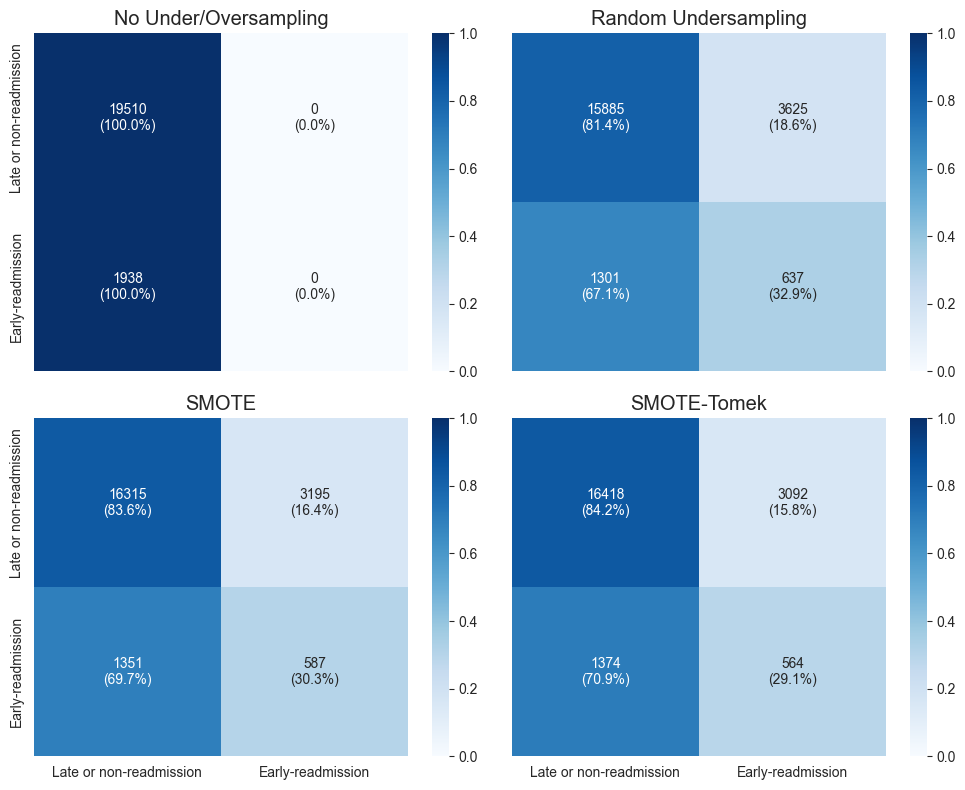

In [73]:
# Combine all confusion matrices into a single plot
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
cm_list = [cm_none_norm, cm_rus_norm, cm_smote_norm, cm_smotetomek_norm]
annotations = [annotations_none, annotations_rus, annotations_smote, annotations_smotetomek]
labels = ['No Under/Oversampling', 'Random Undersampling', 'SMOTE', 'SMOTE-Tomek']

# Define tick labels
xticklabels = ['Late or non-readmission', 'Early-readmission']
yticklabels = ['Late or non-readmission', 'Early-readmission']

for i, cm in enumerate(cm_list):
    ax=axs[i//2, i%2]
    sns.heatmap(
        cm,
        annot=annotations[i],
        cmap='Blues',
        fmt='',
        vmin=0, vmax=1,
        ax=axs[i//2, i%2],
        xticklabels=['Late or non-readmission', 'Early-readmission'],
        yticklabels=['Late or non-readmission', 'Early-readmission']
    )
    ax.set_title(labels[i])
    
    # Hide x-tick labels for the top row
    if i < 2:
        ax.set_xticklabels([])
    # Hide y-tick labels for the right column
    if i % 2 == 1:
        ax.set_yticklabels([])

plt.tight_layout()
plt.show()

Visualizing the scores for each method.

In [74]:
# Combine all metrics into a single DataFrame
data = {
    'Recall': [recall_none, recall_rus, recall_smote, recall_smotetomek],
    'Precision': [precision_none, precision_rus, precision_smote, precision_smotetomek],
    'F1-score': [f1_none, f1_rus, f1_smote, f1_smotetomek],
    'ROC-AUC': [roc_auc_none, roc_auc_rus, roc_auc_smote, roc_auc_smotetomek],
    'Accuracy': [accuracy_none, accuracy_rus, accuracy_smote, accuracy_smotetomek]
}

metrics_df = pd.DataFrame(data, index=labels)
metrics_df

,Recall,Precision,F1-score,ROC-AUC,Accuracy
No Under/Oversampling,0.500000,0.454821,0.476342,0.500000,0.909642
Random Undersampling,0.571444,0.536880,0.535623,0.571444,0.770328
SMOTE,0.569564,0.539367,0.541481,0.569564,0.788046
SMOTE-Tomek,0.566269,0.538521,0.540960,0.566269,0.791775


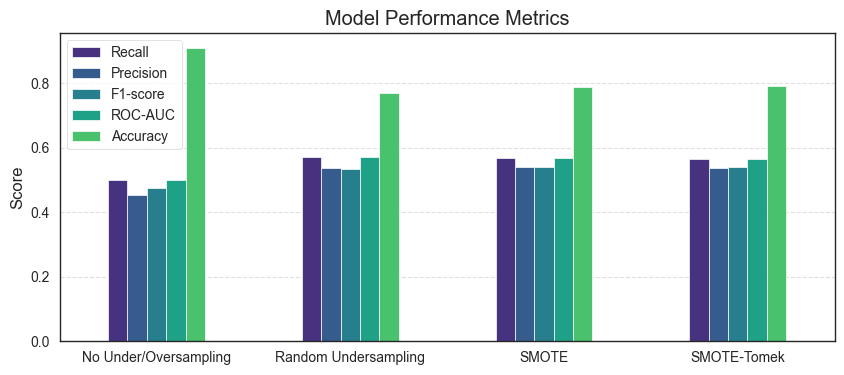

In [75]:
# Visualize all metrics in a bar plot, by coloring each method differently, using SeaBorn barplot and adding grids
sns.set_palette('viridis')
metrics_df.plot(kind='bar', figsize=(10, 4))
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()